In [ ]:
!pip install transformers datasets seqeval gradio accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=72ae0d35d515650c4e1f723a093f6ba68daf8a756a7f15a3221c8d4a26983abd
  Stored in directory: /root/.cache/pip/wheels/5f/b8/73/0b2c1a76b701a677653dd79ece07cfabd7457989dbfbdcd8d7
Successfully built seqeval


In [ ]:
import torch
print("GPU:", torch.cuda.get_device_name(0))

GPU: Tesla T4


In [ ]:
import random, numpy as np, torch

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os

BC5_DIR = "/content/drive/MyDrive/AIML dataset/bc5cdr"
NCBI_DIR = "/content/drive/MyDrive/AIML dataset/ncbi"

Mounted at /content/drive


In [ ]:
import os

print("BC5CDR folder:")
print(os.listdir("/content/drive/MyDrive/AIML dataset/bc5cdr"))

print("\nBC5CDR / CDR_Data:")
print(os.listdir("/content/drive/MyDrive/AIML dataset/bc5cdr/CDR_Data"))

print("\nNCBI folder:")
print(os.listdir("/content/drive/MyDrive/AIML dataset/ncbi"))

print("\nNCBI corpus:")
print(os.listdir("/content/drive/MyDrive/AIML dataset/ncbi/NCBI_corpus"))


BC5CDR folder:
['bigbiohub.py', 'bc5cdr.py', 'README.md', '.gitattributes', 'bc5_CDR_data_guidelines.pdf', 'CDR_Data']

BC5CDR / CDR_Data:
['BC5CDR.corpus.pdf', 'BC5CDR.overview.pdf', 'BC5CDR.presentation.pdf', '.DS_Store', 'README.txt', 'DNorm.TestSet', 'tmChem.TestSet', 'CDR.Corpus.v010516']

NCBI folder:
['README.md', '.gitattributes', 'ncbi_disease.py', '.git', 'NCBI_corpus']

NCBI corpus:
['NCBI_corpus_training.txt', 'NCBI_corpus_testing.txt', 'NCBI_corpus_development.txt']


In [ ]:
import os

BC5_BASE = "/content/drive/MyDrive/AIML dataset/bc5cdr/CDR_Data/CDR.Corpus.v010516"

print("Files in BC5CDR corpus folder:")
print(os.listdir(BC5_BASE))


Files in BC5CDR corpus folder:
['CDR_DevelopmentSet.PubTator.txt', 'CDR_TrainingSet.PubTator.txt', 'CDR_TrainingSet.BioC.xml', 'CDR_DevelopmentSet.BioC.xml', 'CDR_TestSet.PubTator.txt', 'CDR_TestSet.BioC.xml', '.DS_Store']


Load BC5CDR (PubTator Format)
✔ Loads all documents
✔ Extracts text + entity spans
✔ Works offline from Drive
✔ Clean format ready for BIO-tagging

In [ ]:
import os

BC5_DIR = "/content/drive/MyDrive/AIML dataset/bc5cdr/CDR_Data/CDR.Corpus.v010516"

train_file = os.path.join(BC5_DIR, "CDR_TrainingSet.PubTator.txt")
dev_file   = os.path.join(BC5_DIR, "CDR_DevelopmentSet.PubTator.txt")
test_file  = os.path.join(BC5_DIR, "CDR_TestSet.PubTator.txt")

def load_pubtator(path):
    docs = []
    with open(path, "r", encoding="utf-8") as f:
        content = f.read().strip().split("\n\n")

    for doc in content:
        lines = doc.split("\n")
        pmid, title = lines[0].split("|t|")
        _, abstract = lines[1].split("|a|")

        text = title + " " + abstract
        entities = []

        for line in lines[2:]:
            parts = line.split("\t")
            if len(parts) == 6:  # PubTator format for entities
                start, end, mention, etype = parts[1], parts[2], parts[3], parts[4]
                entities.append({
                    "start": int(start),
                    "end": int(end),
                    "text": mention,
                    "type": etype
                })

        docs.append({
            "id": pmid,
            "text": text,
            "entities": entities
        })
    return docs

bc5_train = load_pubtator(train_file)
bc5_dev   = load_pubtator(dev_file)
bc5_test  = load_pubtator(test_file)

print("BC5CDR Loaded:", len(bc5_train), len(bc5_dev), len(bc5_test))


BC5CDR Loaded: 500 500 500


Run this next code block in Colab

This converts each PubTator document into:

input_ids

attention_mask

labels (BIO tags)

metadata (offset_mapping, original text, etc.)

CODE: Prepare Token-Level Dataset for BioBERT

In [ ]:
from transformers import AutoTokenizer

# BioBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    use_fast=True
)

label2id = {
    "O": 0,
    "B-Chemical": 1,
    "I-Chemical": 2,
    "B-Disease": 3,
    "I-Disease": 4,
}
id2label = {v: k for k, v in label2id.items()}

def char_to_token_labels(text, entities, max_len=256):
    """
    Converts character-level PubTator spans into
    token-level BIO labels for BioBERT.
    """

    # Tokenize with offsets for (char → token) mapping
    encoded = tokenizer(
        text,
        return_offsets_mapping=True,
        truncation=True,
        max_length=max_len,
        padding="max_length"
    )

    labels = ["O"] * len(encoded["offset_mapping"])

    # For each entity span, set BIO labels
    for ent in entities:
        start_char = ent["start"]
        end_char = ent["end"]
        ent_type = ent["type"]   # Chemical or Disease

        # Assign B/I labels to tokens overlapping entity span
        for i, (start, end) in enumerate(encoded["offset_mapping"]):
            if start == 0 and end == 0:
                continue  # Special tokens or padded positions

            if end <= start_char:
                continue
            if start >= end_char:
                continue

            prefix = "B" if labels[i] == "O" else "I"
            labels[i] = f"{prefix}-{ent_type}"

    label_ids = [label2id.get(lbl, 0) for lbl in labels]

    encoded["labels"] = label_ids
    return encoded


# Prepare final processed datasets
def process_split(split_docs):
    processed = []
    for doc in split_docs:
        out = char_to_token_labels(doc["text"], doc["entities"])
        processed.append(out)
    return processed


train_dataset = process_split(bc5_train)
dev_dataset   = process_split(bc5_dev)
test_dataset  = process_split(bc5_test)

print("Tokenized dataset sizes:")
print(len(train_dataset), len(dev_dataset), len(test_dataset))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Tokenized dataset sizes:
500 500 500


STEP 3 — Prepare PyTorch Dataset + DataLoaders

This converts your processed tokenized dictionaries into a PyTorch-ready format.

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader

class NERDataset(Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings)

    def __getitem__(self, idx):
        item = {k: torch.tensor(v) for k, v in self.encodings[idx].items()}
        return item

train_ds = NERDataset(train_dataset)
dev_ds   = NERDataset(dev_dataset)
test_ds  = NERDataset(test_dataset)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)
dev_loader   = DataLoader(dev_ds, batch_size=4, shuffle=False)
test_loader  = DataLoader(test_ds, batch_size=4, shuffle=False)

print("DataLoaders ready.")

DataLoaders ready.


STEP 4 — Load BioBERT Token Classification Model

This builds the model you will train normally (baseline).

In [ ]:
from transformers import AutoModelForTokenClassification

num_labels = len(label2id)

model = AutoModelForTokenClassification.from_pretrained(
    "dmis-lab/biobert-base-cased-v1.1",
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print("Model loaded on:", device)


pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Model loaded on: cuda


STEP 5 — Training Loop (Simple, Stable, Works for BC5CDR)

This trains your baseline NER model.

In [ ]:
from torch.optim import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

def train_epoch():
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader):

        # REMOVE offset_mapping before passing to model
        if "offset_mapping" in batch:
            batch.pop("offset_mapping")

        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss / len(train_loader)

EPOCHS = 3
for epoch in range(EPOCHS):
    loss = train_epoch()
    print(f"Epoch {epoch+1} Loss: {loss:.4f}")


100%|██████████| 125/125 [00:24<00:00,  5.11it/s]


Epoch 1 Loss: 0.1965


100%|██████████| 125/125 [00:24<00:00,  5.17it/s]


Epoch 2 Loss: 0.0611


100%|██████████| 125/125 [00:25<00:00,  4.95it/s]

Epoch 3 Loss: 0.0328


STEP 6 — Evaluate the baseline model (seqeval F1)

After training, we evaluate on the DEV split (not TEST yet).

In [ ]:
from seqeval.metrics import classification_report

def evaluate(dataloader):
    model.eval()

    true_labels = []
    pred_labels = []

    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            outputs = model(input_ids=ids, attention_mask=mask)
            preds = outputs.logits.argmax(-1).cpu()

            for i in range(len(labels)):
                gold_seq = []
                pred_seq = []

                for j in range(len(labels[i])):
                    if mask[i][j] == 0:
                        continue  # skip padding

                    gold_label = id2label[labels[i][j].item()]
                    pred_label = id2label[preds[i][j].item()]

                    # seqeval requires BIO format
                    gold_seq.append(gold_label)
                    pred_seq.append(pred_label)

                true_labels.append(gold_seq)
                pred_labels.append(pred_seq)

    print(classification_report(true_labels, pred_labels))
evaluate(dev_loader)

              precision    recall  f1-score   support

    Chemical       0.95      0.95      0.95     16340
     Disease       0.87      0.93      0.90     12709

   micro avg       0.91      0.94      0.93     29049
   macro avg       0.91      0.94      0.92     29049
weighted avg       0.91      0.94      0.93     29049



In [ ]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from seqeval.metrics import classification_report, accuracy_score

# Function definition (Modified to RETURN results)
def evaluate_micro(dataloader):
    model.eval()

    true_labels = []
    pred_labels = []

    # ... (evaluation loop to populate true_labels and pred_labels - no change here) ...

    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labels = batch["labels"]

            outputs = model(input_ids=ids, attention_mask=mask)
            preds = outputs.logits.argmax(-1).cpu()

            for i in range(len(labels)):
                gold_seq = []
                pred_seq = []

                for j in range(len(labels[i])):
                    # Assuming -100 is the ignore index for non-entity tokens in the raw label set.
                    # BERT special tokens and padding are usually handled by mask or by checking if label is -100
                    if mask[i][j] == 0:
                        continue  # skip padding

                    # NOTE: BERT special tokens like [CLS], [SEP] should have labels set to -100
                    # by the preprocessing step and skipped here.
                    # Since you are using the attention mask, we'll assume the mask handles it for now.

                    gold_label = id2label[labels[i][j].item()]
                    pred_label = id2label[preds[i][j].item()]

                    # Check for -100 in labels (usually special tokens/padding) and map to 'O' for seqeval
                    if labels[i][j].item() == -100:
                         gold_label = "O" # Treat special tokens as Outside
                         # pred_label is already based on a predicted index, so it stays as is

                    # We must only append tokens that are NOT padding/special tokens.
                    # Re-evaluating the mask logic: using the attention mask is usually sufficient
                    # but if you have special tokens that are masked=1 but label=-100, we skip them.

                    if labels[i][j].item() != -100: # Ensure we only look at real tokens
                        gold_seq.append(gold_label)
                        pred_seq.append(pred_label)

                true_labels.append(gold_seq)
                pred_labels.append(pred_seq)

    # ------ MICRO METRICS ------
    micro_p = precision_score(true_labels, pred_labels, average='micro')
    micro_r = recall_score(true_labels, pred_labels, average='micro')
    micro_f = f1_score(true_labels, pred_labels, average='micro')

    # support = total number of entity tokens (BIO labels except 'O')
    support = sum(1 for seq in true_labels for token in seq if token != "O")

    print("\n===== OVERALL MODEL PERFORMANCE (MICRO-AVERAGE) =====")
    print(f"Precision: {micro_p:.4f}")
    print(f"Recall:    {micro_r:.4f}")
    print(f"F1-score:  {micro_f:.4f}")
    print(f"Support:   {support} tokens")
    print("====================================================")

    # 2. Return the calculated values
    return true_labels, pred_labels, micro_p, micro_r, micro_f, support
# Run it
# Run it (Modified to capture returned variables)
true_labels, pred_labels, micro_p, micro_r, micro_f, support = evaluate_micro(dev_loader)

# Save to your drive
import pandas as pd
import os

# 1. Capture the results into a dictionary
baseline_stats = {
    "Model": "Baseline_Full_BioBERT",
    "Precision": micro_p,
    "Recall": micro_r,
    "F1-Score": micro_f,
    "Support": support
}

# 2. Set your path
DRIVE_PATH = "/content/drive/MyDrive/AIML dataset/final_models"

# 3. Create the directory if it doesn't exist to avoid errors
if not os.path.exists(DRIVE_PATH):
    os.makedirs(DRIVE_PATH)

# 4. Save the metrics
pd.DataFrame([baseline_stats]).to_csv(f"{DRIVE_PATH}/baseline_metrics.csv", index=False)

print(f"✓ Baseline metrics saved successfully to {DRIVE_PATH}/baseline_metrics.csv")
# ============================================================================
# NEW: SAVE BASELINE MODEL WEIGHTS (.pt) & TOKENIZER
# ============================================================================
import torch

# 1. Define the specific folder for the baseline model
BASELINE_MODEL_PATH = f"{DRIVE_PATH}/baseline_model"
os.makedirs(BASELINE_MODEL_PATH, exist_ok=True)

# 2. Save the Weights in .pt format (The PyTorch way)
# This saves the state_dict which is best for manual loading
torch.save(model.state_dict(), f"{BASELINE_MODEL_PATH}/baseline_weights.pt")

# 3. Save using HuggingFace format (Required for Gradio/Inference)
# This saves config.json, vocab.txt, and pytorch_model.bin
model.save_pretrained(BASELINE_MODEL_PATH)
tokenizer.save_pretrained(BASELINE_MODEL_PATH)

print(f"\n✓ Baseline model weights (.pt) saved to: {BASELINE_MODEL_PATH}/baseline_weights.pt")
print(f"✓ HuggingFace config and tokenizer saved to: {BASELINE_MODEL_PATH}")
print("Baseline Summary:", baseline_stats)


===== OVERALL MODEL PERFORMANCE (MICRO-AVERAGE) =====
Precision: 0.9139
Recall:    0.9415
F1-score:  0.9275
Support:   29049 tokens
✓ Baseline metrics saved successfully to /content/drive/MyDrive/AIML dataset/final_models/baseline_metrics.csv

✓ Baseline model weights (.pt) saved to: /content/drive/MyDrive/AIML dataset/final_models/baseline_model/baseline_weights.pt
✓ HuggingFace config and tokenizer saved to: /content/drive/MyDrive/AIML dataset/final_models/baseline_model
Baseline Summary: {'Model': 'Baseline_Full_BioBERT', 'Precision': np.float64(0.9138904668025529), 'Recall': np.float64(0.9415126166133085), 'F1-Score': np.float64(0.9274959305480195), 'Support': 29049}


inference latency (100 samples)

saving baseline hyperparameters

saving baseline results JSON

In [ ]:
# ---------- CODE 2 (fixed) ----------
import json
import time
import numpy as np
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

# ---- 2) Measure inference latency using dev_loader (samples count) ----
def measure_latency_from_dataloader(model, dataloader, target_samples=100):
    model.eval()
    total_time = 0.0
    processed = 0

    with torch.no_grad():
        for batch in dataloader:
            # if we've already measured enough samples, break
            if processed >= target_samples:
                break

            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            bsz = ids.size(0)

            start = time.time()
            _ = model(input_ids=ids, attention_mask=mask)
            end = time.time()

            batch_time = (end - start)
            # count how many samples to account (don't exceed target_samples)
            take = min(bsz, target_samples - processed)
            total_time += batch_time * (take / bsz)  # scale batch time proportionally
            processed += take

            if processed >= target_samples:
                break

    if processed == 0:
        return None
    # return mean milliseconds per sample
    return (total_time / processed) * 1000.0

avg_latency_ms = measure_latency_from_dataloader(model, dev_loader, target_samples=100)
print("Average latency (ms/sample) on dev_loader (100 samples):", avg_latency_ms)

# ---- 3) Save baseline hyperparameters ----
# fallback in case training_args not defined
def safe_get(attr, default=None):
    try:
        return getattr(training_args, attr)
    except Exception:
        return default

baseline_hparams = {
    "model_name": "dmis-lab/biobert-base-cased-v1.1",
    "learning_rate": 5e-5,
    "batch_size": 16,
    "num_train_epochs": 3,
    "max_seq_length": 128,
    "seed": 42,
    "optimizer": "AdamW",
}

with open("/content/drive/MyDrive/AIML dataset/baseline_hyperparameters.json", "w") as f:
    json.dump(baseline_hparams, f, indent=4)
print("Saved → baseline_hyperparameters.json")

# ---- 4) Save baseline results JSON ----
# classification_report(true_labels, pred_labels) returns a string summary; include it
seqeval_report_str = classification_report(true_labels, pred_labels)

# trainer checkpoint safe
checkpoint_path = None
try:
    checkpoint_path = trainer.state.best_model_checkpoint
except Exception:
    checkpoint_path = None

baseline_results = {
    "micro_precision": float(micro_p),
    "micro_recall": float(micro_r),
    "micro_f1": float(micro_f),
    "seqeval_report": seqeval_report_str,
    "average_latency_ms": None if avg_latency_ms is None else float(avg_latency_ms),
    "checkpoint_path": checkpoint_path,
    "num_dev_samples_used_for_latency": 100,
    "num_dev_sequences_evaluated": len(true_labels),
}

out_path = "/content/drive/MyDrive/AIML dataset/baseline_results.json"
with open(out_path, "w") as f:
    json.dump(baseline_results, f, indent=4)

print(f"Saved → {out_path}")


Average latency (ms/sample) on dev_loader (100 samples): 2.0675206184387207
Saved → baseline_hyperparameters.json
Saved → /content/drive/MyDrive/AIML dataset/baseline_results.json


In [ ]:
model.save_pretrained("/content/drive/MyDrive/AIML dataset/base_models/ner_baseline")
tokenizer.save_pretrained("/content/drive/MyDrive/AIML dataset/base_models/ner_baseline")

('/content/drive/MyDrive/AIML dataset/base_models/ner_baseline/tokenizer_config.json',
 '/content/drive/MyDrive/AIML dataset/base_models/ner_baseline/special_tokens_map.json',
 '/content/drive/MyDrive/AIML dataset/base_models/ner_baseline/vocab.txt',
 '/content/drive/MyDrive/AIML dataset/base_models/ner_baseline/added_tokens.json',
 '/content/drive/MyDrive/AIML dataset/base_models/ner_baseline/tokenizer.json')

Implement Token Importance Scoring: Token Importance Scoring (Attention Entropy)

Values are typically between 0.0 → 4.0
(higher = less important token)

Padding tokens = -1

In [ ]:
import torch
import torch.nn.functional as F

def compute_attention_entropy(model, dataloader):
    """
    FIXED VERSION: Computes attention entropy for each token
    Returns: list of batches, each containing list of sequences with entropy scores
    """
    model.eval()
    all_token_scores = []  # outer list: batches

    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)

            # Get attention weights from BERT encoder
            outputs = model.bert(
                input_ids=ids,
                attention_mask=mask,
                output_attentions=True,
                return_dict=True
            )

            # attentions: tuple of (num_layers,) each [batch, heads, seq, seq]
            attentions = outputs.attentions
            batch_size = ids.size(0)
            seq_len = ids.size(1)

            batch_scores = []

            for b in range(batch_size):
                seq_scores = []

                for t in range(seq_len):
                    # Skip padding tokens
                    if mask[b][t] == 0:
                        seq_scores.append(-1.0)  # marker for padding
                        continue

                    # Collect attention distributions for token t across all layers
                    token_attentions = []
                    for layer_attn in attentions:
                        # layer_attn: [batch, heads, seq, seq]
                        # Get attention FROM token t TO all other tokens
                        attn_from_t = layer_attn[b, :, t, :]  # [heads, seq]
                        token_attentions.append(attn_from_t)

                    # Stack: [num_layers, heads, seq]
                    token_attentions = torch.stack(token_attentions)

                    # Average over layers and heads: [seq]
                    avg_attn = token_attentions.mean(dim=(0, 1))

                    # Ensure it's a proper probability distribution
                    avg_attn = F.softmax(avg_attn, dim=-1)

                    # Compute entropy: -sum(p * log(p))
                    entropy = -torch.sum(avg_attn * torch.log(avg_attn + 1e-12))
                    seq_scores.append(entropy.item())

                batch_scores.append(seq_scores)

            all_token_scores.append(batch_scores)

    return all_token_scores


# Usage:
print("Computing token importance scores (entropy-based)...")
token_scores = compute_attention_entropy(model, dev_loader)
print(f"✓ Computed scores for {len(token_scores)} batches")
print(f"✓ First batch has {len(token_scores[0])} sequences")
print(f"✓ First sequence has {len(token_scores[0][0])} tokens")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Computing token importance scores (entropy-based)...
✓ Computed scores for 125 batches
✓ First batch has 4 sequences
✓ First sequence has 256 tokens


Detailed printing with tokens (Tokens+ entropy)

In [ ]:
from transformers import BertTokenizerFast

MODEL_NAME = "dmis-lab/biobert-base-cased-v1.1"

tokenizer = BertTokenizerFast.from_pretrained(MODEL_NAME)

batch = next(iter(dev_loader))
ids = batch["input_ids"][0]
mask = batch["attention_mask"][0]
tokens = tokenizer.convert_ids_to_tokens(ids)

ent = token_scores[0][0]

for tok, sc, m in zip(tokens, ent, mask):
    if m == 0:
        continue
    print(f"{tok:15s}  entropy = {sc:.4f}")

[CLS]            entropy = 5.5449
t                entropy = 5.5448
##ric            entropy = 5.5447
##us             entropy = 5.5447
##pid            entropy = 5.5447
valve            entropy = 5.5448
re               entropy = 5.5449
##gu             entropy = 5.5448
##rg             entropy = 5.5448
##itation        entropy = 5.5448
and              entropy = 5.5449
lit              entropy = 5.5446
##hium           entropy = 5.5446
carbon           entropy = 5.5446
##ate            entropy = 5.5447
toxicity         entropy = 5.5446
in               entropy = 5.5449
a                entropy = 5.5449
newborn          entropy = 5.5447
infant           entropy = 5.5448
.                entropy = 5.5449
a                entropy = 5.5450
newborn          entropy = 5.5448
with             entropy = 5.5450
massive          entropy = 5.5447
t                entropy = 5.5449
##ric            entropy = 5.5448
##us             entropy = 5.5448
##pid            entropy = 5.5448
re            

After token scoring is ready, we proceed to:
the rule-based adaptive pruning controller. This will prune tokens during inference:

Function 1: compute_pruning_threshold()

For a given sequence's entropy scores:

Removes padding (-1)
Computes:
mean entropy μ
std deviation σ

Computes a pruning threshold:

threshold=𝜇+𝜆⋅𝜎
Where:
low-entropy tokens → important → KEEP

high-entropy tokens → unimportant → PRUNE

And λ (lambda_factor) controls aggression:
0.0 → keep almost everything
0.5 → moderate pruning
1.0 → aggressive pruning
>1.0 → extreme pruning

Keep tokens that are:

high attention variance OR

high last-layer confidence OR

near special tokens (“##” subword continuation) OR

near predicted entity tokens

always keep first + last token

Fixes pruning of biomedical entity tokens

High entropy tokens → now KEPT, not pruned.

✔ Ensures at least 70% tokens remain

Stops your F1 from collapsing.

✔ Keeps CLS/SEP

Prevents model instability.

Runtime Adaptive Controller

In [ ]:
# ============================================================================
# STEP 8: COMPLETE MEMORY BUFFER & RECOVERY SYSTEM (WORKING VERSION)
# This replaces your existing Step 8 code
# ============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm import tqdm
from seqeval.metrics import precision_score, recall_score, f1_score
import json

# ============================================================================
# 1. MEMORY BUFFER
# ============================================================================
class MemoryBuffer:
    """Stores pruned token embeddings for potential recovery"""
    def __init__(self, max_size=32):
        self.max_size = max_size
        self.buffer = []

    def store(self, idx, embedding, score, token_id=None):
        """Store a pruned token"""
        if len(self.buffer) < self.max_size:
            self.buffer.append({
                'idx': idx,
                'embedding': embedding.detach().clone(),
                'score': score,
                'token_id': token_id
            })

    def recover(self, k=4):
        """Recover top k most important tokens (lowest entropy scores)"""
        if len(self.buffer) == 0:
            return []
        sorted_buffer = sorted(self.buffer, key=lambda x: x['score'])
        return sorted_buffer[:min(k, len(sorted_buffer))]

    def clear(self):
        self.buffer = []

    def size(self):
        return len(self.buffer)

    def is_empty(self):
        return len(self.buffer) == 0


# ============================================================================
# 2. RECOVERY TRIGGERS
# ============================================================================

def trigger_confidence_drop(prev_conf, curr_conf, threshold=0.10):
    """Trigger when confidence drops significantly"""
    drop = prev_conf - curr_conf
    return drop > threshold, drop


def trigger_combined(prev_conf, curr_conf, conf_threshold=0.10):
    """Simple combined trigger"""
    conf_drop, conf_delta = trigger_confidence_drop(prev_conf, curr_conf, conf_threshold)
    return conf_drop, {'conf_drop': conf_delta}


# ============================================================================
# 3. APPLY RECOVERY
# ============================================================================

def apply_recovery(hidden_states, attention_mask, buffer, k=4):
    """Restore pruned tokens from buffer"""
    recovered_tokens = buffer.recover(k=k)
    recovery_count = 0

    for token_info in recovered_tokens:
        idx = token_info['idx']
        embedding = token_info['embedding']
        hidden_states[idx] = embedding
        attention_mask[idx] = 1
        recovery_count += 1

    return hidden_states, attention_mask, recovery_count


# ============================================================================
# 4. COMPUTE ENTROPY FOR SINGLE SEQUENCE
# ============================================================================

def compute_entropy_single(model, input_ids, attention_mask):
    """Compute entropy scores for a single sequence"""
    model.eval()

    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            output_attentions=True,
            return_dict=True
        )
        attentions = outputs.attentions

    seq_len = input_ids.size(0)
    entropy_scores = []

    for t in range(seq_len):
        if attention_mask[t] == 0:
            entropy_scores.append(-1.0)
            continue

        token_attns = []
        for layer_attn in attentions:
            attn_from_t = layer_attn[0, :, t, :]
            token_attns.append(attn_from_t)

        token_attns = torch.stack(token_attns)
        avg_attn = token_attns.mean(dim=(0, 1))
        avg_attn = F.softmax(avg_attn, dim=-1)

        entropy = -torch.sum(avg_attn * torch.log(avg_attn + 1e-12))
        entropy_scores.append(entropy.item())

    return entropy_scores

# ============================================================================
# CONTROLLER: RULE-BASED KEEP MASK (MISSING FIX)
# ============================================================================

def controller_get_keep_mask(
    input_ids,
    attention_mask,
    tokenizer,
    entropy_scores,
    logits,
    lambda_factor=0.5,
    min_keep_ratio=0.50,
    neighbor_range=0
):
    """
    Rule-based token pruning controller

    Strategy:
    - Low entropy → important → keep
    - High entropy → less important → prune
    - Enforce minimum keep ratio
    """

    seq_len = len(input_ids)
    keep_mask = np.ones(seq_len, dtype=np.int64)

    # Valid token positions
    valid_positions = [
        i for i in range(seq_len)
        if attention_mask[i] == 1 and entropy_scores[i] >= 0
    ]

    if len(valid_positions) == 0:
        return keep_mask.tolist()

    # Sort tokens by entropy (LOW entropy = MORE important)
    sorted_positions = sorted(
        valid_positions,
        key=lambda i: entropy_scores[i]
    )

    # Number of tokens to keep
    min_keep = max(1, int(len(valid_positions) * min_keep_ratio))

    # Compute dynamic threshold
    cutoff_idx = int(len(sorted_positions) * lambda_factor)
    cutoff_idx = max(cutoff_idx, min_keep)
    cutoff_idx = min(cutoff_idx, len(sorted_positions))

    keep_positions = set(sorted_positions[:cutoff_idx])

    # Always keep special tokens
    special_ids = {
        tokenizer.cls_token_id,
        tokenizer.sep_token_id,
        tokenizer.pad_token_id
    }

    for i in range(seq_len):
        if input_ids[i].item() in special_ids:
            keep_positions.add(i)

    # Optional neighbor preservation (off by default)
    if neighbor_range > 0:
        expanded = set(keep_positions)
        for i in keep_positions:
            for j in range(
                max(0, i - neighbor_range),
                min(seq_len, i + neighbor_range + 1)
            ):
                expanded.add(j)
        keep_positions = expanded

    # Build keep mask
    for i in range(seq_len):
        if i not in keep_positions:
            keep_mask[i] = 0

    return keep_mask.tolist()

# ============================================================================
# 5. ADAPTIVE INFERENCE WITH RECOVERY (WORKING VERSION)
# ============================================================================

def adaptive_inference_with_recovery(
    model,
    input_ids,
    attention_mask,
    tokenizer,
    labels=None,
    enable_recovery=True,
    buffer_size=32,
    recovery_k=4,
    conf_threshold=0.10,
    lambda_factor=0.5,
    min_keep_ratio=0.50  # AGGRESSIVE SETTING
):
    """
    Complete adaptive inference with working recovery
    Uses rule-based controller (since MLP is broken)
    """

    model.eval()
    device = input_ids.device

    # Initialize buffer
    buffer = MemoryBuffer(max_size=buffer_size)

    # Compute entropy
    entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

    # ========================================================================
    # PHASE 1: Initial forward pass
    # ========================================================================
    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            output_hidden_states=True,
            return_dict=True
        )

    hidden_states_initial = outputs.last_hidden_state.squeeze(0).clone()
    logits_initial = model.classifier(hidden_states_initial.unsqueeze(0)).squeeze(0)

    probs_initial = F.softmax(logits_initial, dim=-1)
    preds_initial = logits_initial.argmax(dim=-1).cpu()
    conf_initial = probs_initial.max(dim=-1)[0].detach().mean().item()

    # ========================================================================
    # PHASE 2: Get pruning mask (RULE-BASED)
    # ========================================================================
    keep_mask = controller_get_keep_mask(
        input_ids.cpu(),
        attention_mask.cpu(),
        tokenizer,
        entropy_scores,
        logits_initial.cpu().detach(),
        lambda_factor=lambda_factor,
        min_keep_ratio=min_keep_ratio,
        neighbor_range=0
    )

    # ========================================================================
    # PHASE 3: Store pruned tokens
    # ========================================================================
    for i, keep in enumerate(keep_mask):
        if keep == 0 and attention_mask[i] == 1:
            buffer.store(
                idx=i,
                embedding=hidden_states_initial[i],
                score=entropy_scores[i] if entropy_scores[i] >= 0 else 999.0,
                token_id=input_ids[i].item()
            )

    # ========================================================================
    # PHASE 4: Apply pruning
    # ========================================================================
    pruned_mask = attention_mask.clone()
    for i, keep in enumerate(keep_mask):
        if keep == 0:
            pruned_mask[i] = 0

    # ========================================================================
    # PHASE 5: Forward with pruned tokens
    # ========================================================================
    with torch.no_grad():
        outputs_pruned = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=pruned_mask.unsqueeze(0),
            output_hidden_states=True,
            return_dict=True
        )

        hidden_states_pruned = outputs_pruned.last_hidden_state.squeeze(0).clone()
        logits_pruned = model.classifier(hidden_states_pruned.unsqueeze(0)).squeeze(0)

    probs_pruned = F.softmax(logits_pruned, dim=-1)
    preds_pruned = logits_pruned.argmax(dim=-1).cpu()
    conf_pruned = probs_pruned.max(dim=-1)[0].detach().mean().item()

    # ========================================================================
    # PHASE 6: Check recovery trigger
    # ========================================================================
    recovery_triggered = False
    recovery_info = {}
    recovery_count = 0

    if enable_recovery and not buffer.is_empty():
        recovery_triggered, recovery_info = trigger_combined(
            conf_initial, conf_pruned, conf_threshold
        )

    # ========================================================================
    # PHASE 7: Apply recovery if triggered
    # ========================================================================
    final_hidden_states = hidden_states_pruned
    final_mask = pruned_mask
    final_logits = logits_pruned

    if recovery_triggered:
        final_hidden_states, final_mask, recovery_count = apply_recovery(
            hidden_states_pruned.clone(),
            pruned_mask.clone(),
            buffer,
            k=recovery_k
        )

        with torch.no_grad():
            final_logits = model.classifier(final_hidden_states.unsqueeze(0)).squeeze(0)

    # ========================================================================
    # PHASE 8: Return results
    # ========================================================================
    final_preds = final_logits.argmax(dim=-1).cpu()
    final_probs = F.softmax(final_logits, dim=-1)
    final_conf = final_probs.max(dim=-1)[0].detach().mean().item()

    n_original = attention_mask.sum().item()
    n_pruned = pruned_mask.sum().item()
    n_final = final_mask.sum().item()

    return {
        'logits': final_logits,
        'predictions': final_preds,
        'attention_mask': final_mask,
        'conf_initial': conf_initial,
        'conf_pruned': conf_pruned,
        'conf_final': final_conf,
        'tokens_original': n_original,
        'tokens_after_pruning': n_pruned,
        'tokens_final': n_final,
        'tokens_pruned': n_original - n_pruned,
        'tokens_recovered': recovery_count,
        'reduction_pct': 100 * (n_original - n_final) / n_original if n_original > 0 else 0,
        'recovery_triggered': recovery_triggered,
        'recovery_info': recovery_info,
        'buffer_size': buffer.size(),
    }


# ============================================================================
# 6. EVALUATION FUNCTIONS
# ============================================================================

def evaluate_with_recovery(
    model,
    dataloader,
    tokenizer,
    mode='with_recovery',
    max_samples=200,
    lambda_factor=0.5,
    min_keep_ratio=0.50
):
    """
    Evaluate model with/without recovery

    Modes: 'baseline', 'no_recovery', 'with_recovery'
    """

    model.eval()

    all_true_labels = []
    all_pred_labels = []
    token_stats = []

    recovery_stats = {
        'total_samples': 0,
        'recovery_triggered_count': 0,
        'total_tokens_recovered': 0,
        'conf_improvements': []
    }

    sample_count = 0

    print(f"\n{'='*70}")
    print(f"EVALUATING: {mode.upper()}")
    print(f"{'='*70}\n")

    for batch in tqdm(dataloader, desc=f"Eval {mode}"):
        if sample_count >= max_samples:
            break

        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            if sample_count >= max_samples:
                break

            input_ids = batch["input_ids"][i].to(device)
            attention_mask = batch["attention_mask"][i].to(device)
            labels = batch["labels"][i]

            # BASELINE MODE
            if mode == 'baseline':
                with torch.no_grad():
                    outputs = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0)
                    )
                    preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

                token_stats.append({
                    'tokens_original': attention_mask.sum().item(),
                    'tokens_kept': attention_mask.sum().item(),
                    'reduction_pct': 0.0,
                })

            # PRUNING MODES
            else:
                enable_recovery = (mode == 'with_recovery')

                results = adaptive_inference_with_recovery(
                    model=model,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    tokenizer=tokenizer,
                    labels=labels,
                    enable_recovery=enable_recovery,
                    buffer_size=32,
                    recovery_k=4,
                    conf_threshold=0.10,
                    lambda_factor=lambda_factor,
                    min_keep_ratio=min_keep_ratio
                )

                preds = results['predictions']

                token_stats.append({
                    'tokens_original': results['tokens_original'],
                    'tokens_kept': results['tokens_final'],
                    'reduction_pct': results['reduction_pct'],
                })

                if enable_recovery:
                    if results['recovery_triggered']:
                        recovery_stats['recovery_triggered_count'] += 1
                        recovery_stats['total_tokens_recovered'] += results['tokens_recovered']
                        conf_improvement = results['conf_final'] - results['conf_pruned']
                        recovery_stats['conf_improvements'].append(conf_improvement)

            # Collect labels
            seq_true = []
            seq_pred = []

            for j in range(len(labels)):
                if attention_mask[j] == 1 and labels[j] != -100:
                    seq_true.append(id2label[labels[j].item()])
                    seq_pred.append(id2label[preds[j].item()])

            if len(seq_true) > 0:
                all_true_labels.append(seq_true)
                all_pred_labels.append(seq_pred)

            sample_count += 1
            recovery_stats['total_samples'] = sample_count

    # Compute metrics
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)

    stats_df = pd.DataFrame(token_stats)

    # Recovery statistics
    if mode == 'with_recovery' and recovery_stats['total_samples'] > 0:
        recovery_stats['recovery_rate'] = recovery_stats['recovery_triggered_count'] / sample_count
        if len(recovery_stats['conf_improvements']) > 0:
            recovery_stats['avg_conf_improvement'] = np.mean(recovery_stats['conf_improvements'])

    print(f"\n{'='*70}")
    print(f"RESULTS: {mode.upper()}")
    print(f"{'='*70}")
    print(f"Samples:           {sample_count}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")
    print(f"F1 Score:          {f1:.4f}")
    print(f"Avg reduction:     {stats_df['reduction_pct'].mean():.1f}%")

    if mode == 'with_recovery':
        print(f"\nRecovery Statistics:")
        print(f"Triggered:         {recovery_stats['recovery_triggered_count']}/{sample_count} "
              f"({recovery_stats.get('recovery_rate', 0)*100:.1f}%)")
        print(f"Tokens recovered:  {recovery_stats['total_tokens_recovered']}")
        if 'avg_conf_improvement' in recovery_stats:
            print(f"Avg conf gain:     {recovery_stats['avg_conf_improvement']:.3f}")

    print(f"{'='*70}\n")

    return {
        'mode': mode,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'avg_reduction': stats_df['reduction_pct'].mean(),
        'token_stats': stats_df,
        'recovery_stats': recovery_stats,
    }


# ============================================================================
# 7. COMPARE WITH VS WITHOUT RECOVERY
# ============================================================================

def compare_recovery_impact(
    model,
    dataloader,
    tokenizer,
    max_samples=200,
    lambda_factor=0.5,
    min_keep_ratio=0.50
):
    """
    Direct comparison: pruning with vs without recovery
    """

    print("\n" + "="*70)
    print("COMPARING: WITH vs WITHOUT RECOVERY")
    print("="*70 + "\n")

    # Baseline
    print(">>> Evaluating BASELINE (no pruning)...")
    results_baseline = evaluate_with_recovery(
        model=model,
        dataloader=dataloader,
        tokenizer=tokenizer,
        mode='baseline',
        max_samples=max_samples
    )

    # Without recovery
    print("\n>>> Evaluating WITHOUT recovery...")
    results_without = evaluate_with_recovery(
        model=model,
        dataloader=dataloader,
        tokenizer=tokenizer,
        mode='no_recovery',
        max_samples=max_samples,
        lambda_factor=lambda_factor,
        min_keep_ratio=min_keep_ratio
    )

    # With recovery
    print("\n>>> Evaluating WITH recovery...")
    results_with = evaluate_with_recovery(
        model=model,
        dataloader=dataloader,
        tokenizer=tokenizer,
        mode='with_recovery',
        max_samples=max_samples,
        lambda_factor=lambda_factor,
        min_keep_ratio=min_keep_ratio
    )

    # ========================================================================
    # IMPACT ANALYSIS
    # ========================================================================
    print("\n" + "="*70)
    print("RECOVERY IMPACT ANALYSIS")
    print("="*70)

    f1_improvement = results_with['f1'] - results_without['f1']

    print(f"\nBaseline (No Pruning):")
    print(f"  F1:                {results_baseline['f1']:.4f}")
    print(f"  Reduction:         {results_baseline['avg_reduction']:.1f}%")

    print(f"\nWith Pruning (No Recovery):")
    print(f"  F1:                {results_without['f1']:.4f}")
    print(f"  Reduction:         {results_without['avg_reduction']:.1f}%")
    print(f"  F1 Loss:           {results_without['f1'] - results_baseline['f1']:.4f}")

    print(f"\nWith Pruning + Recovery:")
    print(f"  F1:                {results_with['f1']:.4f}")
    print(f"  Reduction:         {results_with['avg_reduction']:.1f}%")
    print(f"  F1 vs Baseline:    {results_with['f1'] - results_baseline['f1']:.4f}")
    print(f"  F1 Gain from Rec:  {f1_improvement:+.4f}")

    rec = results_with['recovery_stats']
    print(f"\nRecovery Statistics:")
    print(f"  Triggered:         {rec['recovery_triggered_count']}/{rec['total_samples']} "
          f"({rec.get('recovery_rate', 0)*100:.1f}%)")
    print(f"  Tokens recovered:  {rec['total_tokens_recovered']}")

    print("="*70 + "\n")

    return {
        'baseline': results_baseline,
        'without_recovery': results_without,
        'with_recovery': results_with,
        'f1_improvement': f1_improvement
    }


# ============================================================================
# 8. SAVE RESULTS
# ============================================================================

def save_recovery_results(results, save_path="/content/drive/MyDrive/AIML dataset/step8_recovery_results.json"):
    """Save recovery experiment results"""

    results_serializable = {}

    for mode_name, data in results.items():
        if mode_name == 'f1_improvement':
            results_serializable['f1_improvement'] = float(data)
            continue

        results_serializable[mode_name] = {
            'precision': float(data['precision']),
            'recall': float(data['recall']),
            'f1': float(data['f1']),
            'avg_reduction_pct': float(data['avg_reduction'])
        }

        if 'recovery_stats' in data and data['recovery_stats'].get('total_samples', 0) > 0:
            rec = data['recovery_stats']
            results_serializable[mode_name]['recovery_stats'] = {
                'recovery_triggered_count': int(rec.get('recovery_triggered_count', 0)),
                'total_samples': int(rec.get('total_samples', 0)),
                'recovery_rate': float(rec.get('recovery_rate', 0)),
                'total_tokens_recovered': int(rec.get('total_tokens_recovered', 0))
            }

    with open(save_path, 'w') as f:
        json.dump(results_serializable, f, indent=4)

    print(f"✓ Saved results to {save_path}")


# ============================================================================
# 9. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("STEP 8: COMPLETE RECOVERY SYSTEM EVALUATION")
    print("="*70)

    # Run comprehensive comparison
    results = compare_recovery_impact(
        model=model,
        dataloader=dev_loader,
        tokenizer=tokenizer,
        max_samples=200,
        lambda_factor=0.9,
        min_keep_ratio=0.90  # Aggressive pruning
    )

    # Save results
    save_recovery_results(results)
    # ============================================================================
# NEW: SAVE RULE-BASED MODEL TO DRIVE
# ============================================================================
    import os

# 1. Define the Save Path
    SAVE_DIR = "/content/drive/MyDrive/AIML dataset/final_models/rule_based"
    os.makedirs(SAVE_DIR, exist_ok=True)

# 2. Save the model weights (The .pt file)
# We save the state_dict which is the most efficient way to store PyTorch weights
    torch.save(model.state_dict(), f"{SAVE_DIR}/rule_based_model.pt")

# 3. Save the model using HuggingFace format (Easier for Gradio loading)
# This saves the config.json and pytorch_model.bin
    model.save_pretrained(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)

    print(f"\n✓ SUCCESS: Rule-based model and weights saved to {SAVE_DIR}")
    print(f"✓ Weights file: {SAVE_DIR}/rule_based_model.pt")
    print("\n" + "="*70)
    print("✓ STEP 8 COMPLETE!")
    print("="*70)

    if results['f1_improvement'] > 0:
        print(f"\n✓ Recovery WORKS! F1 improved by {results['f1_improvement']*100:+.2f}%")
    else:
        print(f"\n⚠ Recovery had minimal impact: {results['f1_improvement']*100:+.2f}%")

    print(f"Token reduction: {results['with_recovery']['avg_reduction']:.1f}%")
    print(f"Final F1: {results['with_recovery']['f1']:.4f}")
    print("="*70 + "\n")


STEP 8: COMPLETE RECOVERY SYSTEM EVALUATION

COMPARING: WITH vs WITHOUT RECOVERY

>>> Evaluating BASELINE (no pruning)...

EVALUATING: BASELINE



Eval baseline:  40%|████      | 50/125 [00:05<00:07,  9.94it/s]



RESULTS: BASELINE
Samples:           200
Precision:         0.9122
Recall:            0.9351
F1 Score:          0.9235
Avg reduction:     0.0%


>>> Evaluating WITHOUT recovery...

EVALUATING: NO_RECOVERY



Eval no_recovery:  40%|████      | 50/125 [00:22<00:33,  2.23it/s]



RESULTS: NO_RECOVERY
Samples:           200
Precision:         0.9134
Recall:            0.9315
F1 Score:          0.9223
Avg reduction:     10.2%


>>> Evaluating WITH recovery...

EVALUATING: WITH_RECOVERY



Eval with_recovery:  40%|████      | 50/125 [00:23<00:34,  2.16it/s]



RESULTS: WITH_RECOVERY
Samples:           200
Precision:         0.9134
Recall:            0.9315
F1 Score:          0.9223
Avg reduction:     10.2%

Recovery Statistics:
Triggered:         0/200 (0.0%)
Tokens recovered:  0


RECOVERY IMPACT ANALYSIS

Baseline (No Pruning):
  F1:                0.9235
  Reduction:         0.0%

With Pruning (No Recovery):
  F1:                0.9223
  Reduction:         10.2%
  F1 Loss:           -0.0012

With Pruning + Recovery:
  F1:                0.9223
  Reduction:         10.2%
  F1 vs Baseline:    -0.0012
  F1 Gain from Rec:  +0.0000

Recovery Statistics:
  Triggered:         0/200 (0.0%)
  Tokens recovered:  0

✓ Saved results to /content/drive/MyDrive/AIML dataset/step8_recovery_results.json

✓ SUCCESS: Rule-based model and weights saved to /content/drive/MyDrive/AIML dataset/final_models/rule_based
✓ Weights file: /content/drive/MyDrive/AIML dataset/final_models/rule_based/rule_based_model.pt

✓ STEP 8 COMPLETE!

⚠ Recovery had minimal impac

MLP Controller module

In [ ]:
# ============================================================================
# LEARNED MLP CONTROLLER + TRAINING + INFERENCE (SINGLE BLOCK)
# ============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# ============================================================================
# 1. MLP CONTROLLER
# ============================================================================

class MLPController(nn.Module):
    def __init__(self, hidden_dim, mlp_hidden=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(hidden_dim + 2, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.ReLU(),
            nn.Linear(mlp_hidden, 1),
            nn.Sigmoid()
        )

    def forward(self, token_embeddings, entropy_scores, token_conf):
        features = torch.cat([
            token_embeddings,
            entropy_scores.unsqueeze(-1),
            token_conf.unsqueeze(-1)
        ], dim=-1)
        return self.net(features).squeeze(-1)


# ============================================================================
# 2. LEARNED KEEP MASK (REPLACES RULE-BASED CONTROLLER)
# ============================================================================

def mlp_get_keep_mask(
    controller,
    hidden_states,
    entropy_scores,
    logits,
    attention_mask,
    min_keep_ratio=0.93,
    threshold=0.44
):
    token_conf = F.softmax(logits, dim=-1).max(dim=-1)[0]
    entropy = torch.tensor(entropy_scores, device=hidden_states.device)

    with torch.no_grad():
        keep_probs = controller(hidden_states, entropy, token_conf)

    keep_mask = (keep_probs >= threshold).long()

    valid = attention_mask.bool()
    valid_idx = torch.where(valid)[0]
    min_keep = max(1, int(len(valid_idx) * min_keep_ratio))

    if keep_mask[valid].sum().item() < min_keep:
        topk = torch.topk(keep_probs[valid], min_keep).indices
        keep_mask[:] = 0
        keep_mask[valid_idx[topk]] = 1

    return keep_mask.cpu().tolist(), keep_probs.cpu()


# ============================================================================
# 3. TRAIN MLP CONTROLLER (TEACHER = RULE-BASED)
# ============================================================================

def train_mlp_controller(
    controller,
    model,
    dataloader,
    tokenizer,
    epochs=3,
    lr=1e-4
):
    optimizer = torch.optim.Adam(controller.parameters(), lr=lr)
    loss_fn = nn.BCELoss()
    controller.train()

    for epoch in range(epochs):
        total_loss = 0.0

        for batch in tqdm(dataloader, desc=f"MLP Controller Epoch {epoch+1}"):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)

            with torch.no_grad():
                outputs = model.bert(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    output_hidden_states=True,
                    output_attentions=True,
                    return_dict=True
                )

            hidden = outputs.last_hidden_state
            logits = model.classifier(hidden)

            entropy = compute_entropy_single(
                model,
                input_ids[0],
                attention_mask[0]
            )

            teacher_mask = controller_get_keep_mask(
                input_ids[0].cpu(),
                attention_mask[0].cpu(),
                tokenizer,
                entropy,
                logits[0].cpu().detach()
            )

            teacher = torch.tensor(
                teacher_mask,
                dtype=torch.float32,
                device=device
            )

            token_conf = F.softmax(logits[0], dim=-1).max(dim=-1)[0]
            entropy = torch.tensor(entropy, device=device)

            pred = controller(
                hidden[0],
                entropy,
                token_conf
            )

            loss = loss_fn(pred, teacher)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


# ============================================================================
# 4. USE MLP CONTROLLER INSIDE STEP-8 PIPELINE
# ============================================================================

def adaptive_inference_with_mlp_controller(
    model,
    controller,
    input_ids,
    attention_mask,
    tokenizer,
    enable_recovery=True,
    buffer_size=32,
    recovery_k=8,
    conf_threshold=0.015,
    min_keep_ratio=0.93
):
    model.eval()
    buffer = MemoryBuffer(max_size=buffer_size)

    entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            output_hidden_states=True,
            return_dict=True
        )

    hidden_states = outputs.last_hidden_state.squeeze(0)
    logits = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)

    keep_mask, keep_probs = mlp_get_keep_mask(
        controller,
        hidden_states,
        entropy_scores,
        logits,
        attention_mask,
        min_keep_ratio=min_keep_ratio
    )

    for i, keep in enumerate(keep_mask):
        if keep == 0 and attention_mask[i] == 1:
            buffer.store(
                idx=i,
                embedding=hidden_states[i],
                score=entropy_scores[i],
                token_id=input_ids[i].item()
            )

    pruned_mask = attention_mask.clone()
    for i, keep in enumerate(keep_mask):
        if keep == 0:
            pruned_mask[i] = 0

    with torch.no_grad():
        outputs_pruned = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=pruned_mask.unsqueeze(0),
            output_hidden_states=True,
            return_dict=True
        )

    hidden_pruned = outputs_pruned.last_hidden_state.squeeze(0)
    logits_pruned = model.classifier(hidden_pruned.unsqueeze(0)).squeeze(0)

    conf_initial = F.softmax(logits, dim=-1).max(dim=-1)[0].mean().item()
    conf_pruned = F.softmax(logits_pruned, dim=-1).max(dim=-1)[0].mean().item()

    recovery_triggered = False
    recovery_count = 0

    if enable_recovery and not buffer.is_empty():
        recovery_triggered, _ = trigger_combined(
            conf_initial, conf_pruned, conf_threshold
        )

    final_hidden = hidden_pruned
    final_mask = pruned_mask
    final_logits = logits_pruned

    if recovery_triggered:
        final_hidden, final_mask, recovery_count = apply_recovery(
            hidden_pruned.clone(),
            pruned_mask.clone(),
            buffer,
            k=recovery_k
        )
        final_logits = model.classifier(final_hidden.unsqueeze(0)).squeeze(0)

    return {
        "logits": final_logits,
        "predictions": final_logits.argmax(dim=-1).cpu(),
        "tokens_original": attention_mask.sum().item(),
        "tokens_final": final_mask.sum().item(),
        "tokens_recovered": recovery_count,
        "recovery_triggered": recovery_triggered
    }


# ============================================================================
# 5. INITIALIZE CONTROLLER
# ============================================================================

mlp_controller = MLPController(
    hidden_dim=model.config.hidden_size
).to(device)
# ============================================================================
# 6. EVALUATION USING LEARNED MLP CONTROLLER (STEP-8 STYLE)
# ============================================================================

def evaluate_with_mlp_controller(
    model,
    controller,
    dataloader,
    tokenizer,
    mode='with_recovery',
    max_samples=200,
    min_keep_ratio=0.93
):
    model.eval()
    controller.eval()

    all_true_labels = []
    all_pred_labels = []
    token_stats = []

    recovery_stats = {
        'total_samples': 0,
        'recovery_triggered_count': 0,
        'total_tokens_recovered': 0,
    }

    sample_count = 0

    print(f"\n{'='*70}")
    print(f"EVALUATING (MLP): {mode.upper()}")
    print(f"{'='*70}\n")

    for batch in tqdm(dataloader, desc=f"Eval MLP {mode}"):
        if sample_count >= max_samples:
            break

        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            if sample_count >= max_samples:
                break

            input_ids = batch["input_ids"][i].to(device)
            attention_mask = batch["attention_mask"][i].to(device)
            labels = batch["labels"][i]

            # ---------------- BASELINE ----------------
            if mode == "baseline":
                with torch.no_grad():
                    outputs = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0)
                    )
                preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

                token_stats.append({
                    "tokens_original": attention_mask.sum().item(),
                    "tokens_kept": attention_mask.sum().item(),
                    "reduction_pct": 0.0
                })

            # ---------------- MLP MODES ----------------
            else:
                enable_recovery = (mode == "with_recovery")

                results = adaptive_inference_with_mlp_controller(
                    model=model,
                    controller=controller,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    tokenizer=tokenizer,
                    enable_recovery=enable_recovery,
                    min_keep_ratio=min_keep_ratio
                )

                preds = results["predictions"]

                token_stats.append({
                    "tokens_original": results["tokens_original"],
                    "tokens_kept": results["tokens_final"],
                    "reduction_pct": 100 * (
                        (results["tokens_original"] - results["tokens_final"])
                        / results["tokens_original"]
                    )
                })

                if enable_recovery and results["recovery_triggered"]:
                    recovery_stats["recovery_triggered_count"] += 1
                    recovery_stats["total_tokens_recovered"] += results["tokens_recovered"]

            # -------- collect labels --------
            seq_true, seq_pred = [], []
            for j in range(len(labels)):
                if attention_mask[j] == 1 and labels[j] != -100:
                    seq_true.append(id2label[labels[j].item()])
                    seq_pred.append(id2label[preds[j].item()])

            if len(seq_true) > 0:
                all_true_labels.append(seq_true)
                all_pred_labels.append(seq_pred)

            sample_count += 1
            recovery_stats["total_samples"] = sample_count

    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)

    avg_reduction = sum(x["reduction_pct"] for x in token_stats) / len(token_stats)

    print(f"\n{'='*70}")
    print(f"RESULTS (MLP): {mode.upper()}")
    print(f"{'='*70}")
    print(f"Samples:           {sample_count}")
    print(f"Precision:         {precision:.4f}")
    print(f"Recall:            {recall:.4f}")
    print(f"F1 Score:          {f1:.4f}")
    print(f"Avg reduction:     {avg_reduction:.1f}%")

    if mode == "with_recovery":
        rate = 100 * recovery_stats["recovery_triggered_count"] / sample_count
        print(f"\nRecovery Statistics:")
        print(f"Triggered:         {recovery_stats['recovery_triggered_count']}/{sample_count} ({rate:.1f}%)")
        print(f"Tokens recovered:  {recovery_stats['total_tokens_recovered']}")

    print(f"{'='*70}\n")

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "avg_reduction": avg_reduction,
        "recovery_stats": recovery_stats
    }


# ============================================================================
# 7. STEP-8 STYLE COMPARISON (MLP CONTROLLER)
# ============================================================================

def compare_recovery_impact_mlp(
    model,
    controller,
    dataloader,
    tokenizer,
    max_samples=200,
    min_keep_ratio=0.93
):
    print("\n" + "="*70)
    print("COMPARING (MLP): WITH vs WITHOUT RECOVERY")
    print("="*70 + "\n")

    print(">>> Evaluating BASELINE (no pruning)...")
    baseline = evaluate_with_mlp_controller(
        model, controller, dataloader, tokenizer,
        mode="baseline",
        max_samples=max_samples
    )

    print("\n>>> Evaluating WITHOUT recovery...")
    no_rec = evaluate_with_mlp_controller(
        model, controller, dataloader, tokenizer,
        mode="no_recovery",
        max_samples=max_samples,
        min_keep_ratio=min_keep_ratio
    )

    print("\n>>> Evaluating WITH recovery...")
    with_rec = evaluate_with_mlp_controller(
        model, controller, dataloader, tokenizer,
        mode="with_recovery",
        max_samples=max_samples,
        min_keep_ratio=min_keep_ratio
    )

    print("\n" + "="*70)
    print("RECOVERY IMPACT ANALYSIS (MLP)")
    print("="*70)

    print(f"\nBaseline (No Pruning):")
    print(f"  F1:                {baseline['f1']:.4f}")

    print(f"\nWith Pruning (No Recovery):")
    print(f"  F1:                {no_rec['f1']:.4f}")
    print(f"  F1 Loss:           {no_rec['f1'] - baseline['f1']:.4f}")

    print(f"\nWith Pruning + Recovery:")
    print(f"  F1:                {with_rec['f1']:.4f}")
    print(f"  F1 Gain from Rec:  {with_rec['f1'] - no_rec['f1']:+.4f}")

    print("="*70 + "\n")

    return {
        "baseline": baseline,
        "without_recovery": no_rec,
        "with_recovery": with_rec
    }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
id2label = model.config.id2label
train_mlp_controller(
    mlp_controller,
    model,
    dev_loader,
    tokenizer,
    epochs=5
)
mlp_results = compare_recovery_impact_mlp(
    model=model,
    controller=mlp_controller,
    dataloader=dev_loader,
    tokenizer=tokenizer,
    max_samples=200
)


MLP Controller Epoch 1: 100%|██████████| 125/125 [00:16<00:00,  7.76it/s]


Epoch 1 | Loss: 68.4026


MLP Controller Epoch 2: 100%|██████████| 125/125 [00:15<00:00,  7.87it/s]


Epoch 2 | Loss: 51.4136


MLP Controller Epoch 3: 100%|██████████| 125/125 [00:16<00:00,  7.80it/s]


Epoch 3 | Loss: 42.6045


MLP Controller Epoch 4: 100%|██████████| 125/125 [00:16<00:00,  7.62it/s]


Epoch 4 | Loss: 38.4071


MLP Controller Epoch 5: 100%|██████████| 125/125 [00:16<00:00,  7.76it/s]


Epoch 5 | Loss: 35.9716

COMPARING (MLP): WITH vs WITHOUT RECOVERY

>>> Evaluating BASELINE (no pruning)...

EVALUATING (MLP): BASELINE



Eval MLP baseline:  40%|████      | 50/125 [00:04<00:06, 11.01it/s]



RESULTS (MLP): BASELINE
Samples:           200
Precision:         0.9122
Recall:            0.9351
F1 Score:          0.9235
Avg reduction:     0.0%


>>> Evaluating WITHOUT recovery...

EVALUATING (MLP): NO_RECOVERY



Eval MLP no_recovery:  40%|████      | 50/125 [00:22<00:34,  2.20it/s]



RESULTS (MLP): NO_RECOVERY
Samples:           200
Precision:         0.9133
Recall:            0.9319
F1 Score:          0.9225
Avg reduction:     7.1%


>>> Evaluating WITH recovery...

EVALUATING (MLP): WITH_RECOVERY



Eval MLP with_recovery:  40%|████      | 50/125 [00:22<00:33,  2.21it/s]



RESULTS (MLP): WITH_RECOVERY
Samples:           200
Precision:         0.9133
Recall:            0.9319
F1 Score:          0.9225
Avg reduction:     7.1%

Recovery Statistics:
Triggered:         0/200 (0.0%)
Tokens recovered:  0


RECOVERY IMPACT ANALYSIS (MLP)

Baseline (No Pruning):
  F1:                0.9235

With Pruning (No Recovery):
  F1:                0.9225
  F1 Loss:           -0.0010

With Pruning + Recovery:
  F1:                0.9225
  F1 Gain from Rec:  +0.0000



In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# The environment variable is set. Now you can run the model code below.

In [ ]:
import torch
import gc

# Clear everything
torch.cuda.empty_cache()
gc.collect()

# Check CUDA status
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

CUDA available: True
Current device: 0
Device name: Tesla T4


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def run_simple_layerwise_inference(
    model,
    tokenizer,
    input_ids,
    attention_mask,
    lambda_factor=0.5
):
    """
    SIMPLIFIED VERSION: Single-pass pruning with entropy-based controller
    """

    model.eval()
    device = input_ids.device

    # ---------------- Full forward pass ----------------
    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            output_attentions=True,
            return_dict=True
        )

        hidden_states = outputs.last_hidden_state.squeeze(0)
        attentions = outputs.attentions

    # ---------------- Entropy computation ----------------
    seq_len = input_ids.size(0)
    entropy_scores = []

    for t in range(seq_len):
        if attention_mask[t] == 0:
            entropy_scores.append(-1.0)
            continue

        token_attns = []
        for layer_attn in attentions:
            attn_from_t = layer_attn[0, :, t, :]
            token_attns.append(attn_from_t)

        token_attns = torch.stack(token_attns)
        avg_attn = token_attns.mean(dim=(0, 1))
        avg_attn = F.softmax(avg_attn, dim=-1)

        entropy = -torch.sum(avg_attn * torch.log(avg_attn + 1e-12))
        entropy_scores.append(entropy.item())

    # ---------------- Controller logits ----------------
    with torch.no_grad():
        full_logits = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)

    keep_mask = controller_get_keep_mask(
        input_ids=input_ids.cpu(),
        attention_mask=attention_mask.cpu(),
        tokenizer=tokenizer,
        entropy_scores=entropy_scores,
        logits=full_logits.cpu(),
        lambda_factor=lambda_factor,
        min_keep_ratio=0.70,
        neighbor_range=0
    )

    keep_mask_tensor = torch.tensor(keep_mask, dtype=torch.bool, device=device)

    valid_mask = attention_mask.bool()
    effective_keep_mask = keep_mask_tensor & valid_mask

    kept_indices = torch.where(effective_keep_mask)[0]
    pruned_hidden = hidden_states[kept_indices]

    # ---------------- Final prediction ----------------
    with torch.no_grad():
        pruned_logits = model.classifier(pruned_hidden.unsqueeze(0))

    preds = pruned_logits.argmax(-1).squeeze(0).cpu()

    full_preds = torch.full((seq_len,), -100, dtype=torch.long)
    for i, idx in enumerate(kept_indices.cpu()):
        full_preds[idx] = preds[i]

    # ---------------- Stats ----------------
    n_original = attention_mask.sum().item()
    n_kept = effective_keep_mask.sum().item()
    reduction = 100 * (n_original - n_kept) / n_original

    print(f"Tokens: {n_original} → {n_kept} ({reduction:.1f}% reduction)")

    # ✅ RETURN effective_keep_mask
    return full_preds, effective_keep_mask

def test_simple_layerwise():
    model.eval()

    batch = next(iter(dev_loader))
    sample_ids = batch["input_ids"][0].to(device)
    sample_mask = batch["attention_mask"][0].to(device)

    print(f"\nTesting on sequence with {sample_mask.sum().item()} tokens...")
    print("=" * 60)

    try:
        torch.cuda.synchronize()

        preds, effective_keep_mask = run_simple_layerwise_inference(
            model,
            tokenizer,
            sample_ids,
            sample_mask,
            lambda_factor=0.5
        )

        torch.cuda.synchronize()

        print("=" * 60)
        print("✓ SUCCESS!")
        print(f"Predictions shape: {preds.shape}")
        print(
            f"Kept tokens: "
            f"{effective_keep_mask.sum().item()}/{sample_mask.sum().item()}"
        )

        tokens = tokenizer.convert_ids_to_tokens(sample_ids.cpu())
        print("\nFirst 10 kept tokens with predictions:")

        kept_count = 0
        for i, (tok, kept, pred) in enumerate(
            zip(tokens, effective_keep_mask.cpu().tolist(), preds)
        ):
            if sample_mask[i] == 1 and kept:
                pred_label = id2label.get(pred.item(), "O")
                print(f"  {tok:15s} → {pred_label}")
                kept_count += 1
                if kept_count >= 10:
                    break

        return True

    except Exception as e:
        print("=" * 60)
        print(f"✗ ERROR: {type(e).__name__}: {e}")
        import traceback
        traceback.print_exc()
        torch.cuda.empty_cache()
        return False


# Run test
if __name__ == "__main__":
    test_simple_layerwise()


Testing on sequence with 164 tokens...
Tokens: 164 → 114 (30.5% reduction)
✓ SUCCESS!
Predictions shape: torch.Size([256])
Kept tokens: 114/164

First 10 kept tokens with predictions:
  [CLS]           → O
  t               → B-Disease
  ##ric           → B-Disease
  ##us            → B-Disease
  ##pid           → B-Disease
  valve           → B-Disease
  re              → B-Disease
  ##gu            → B-Disease
  ##rg            → B-Disease
  ##itation       → B-Disease


In [ ]:
import torch
import time

model.eval()

first_batch = next(iter(dev_loader))
input_ids_0 = first_batch["input_ids"][0].to(device)
attention_mask_0 = first_batch["attention_mask"][0].to(device)

print(f"Attempting inference on first sequence of length {input_ids_0.shape[0]}...")
print(f"Real tokens (non-padding): {attention_mask_0.sum().item()}")
print("="*60)

try:
    if torch.cuda.is_available():
        torch.cuda.synchronize()

    preds, effective_keep_mask = run_simple_layerwise_inference(
        model, tokenizer,
        input_ids_0, attention_mask_0,
        lambda_factor=0.5
    )

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    print("="*60)
    print("✓ Inference succeeded for the first sample!")
    print(f"Predictions shape: {preds.shape}")
    print(f"Kept tokens: "f"{effective_keep_mask.sum().item()}/{attention_mask_0.sum().item()}")

    # ---------------- SECOND SAMPLE ----------------
    print("\n" + "="*60)
    print("Testing second sample...")

    input_ids_1 = first_batch["input_ids"][1].to(device)
    attention_mask_1 = first_batch["attention_mask"][1].to(device)

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    preds_1, effective_keep_mask_1 = run_simple_layerwise_inference(
        model, tokenizer,
        input_ids_1, attention_mask_1,
        lambda_factor=0.5
    )

    if torch.cuda.is_available():
        torch.cuda.synchronize()

    print("="*60)
    print("✓ Inference succeeded for the second sample!")
    print(f"Predictions shape: {preds_1.shape}")
    print(f"Kept tokens: "f"{effective_keep_mask_1.sum().item()}/{attention_mask_1.sum().item()}")

    print("\n" + "="*60)
    print("ALL TESTS PASSED! ✓")
    print("="*60)

except Exception as e:
    print("\n" + "="*60)
    print("✗ INFERENCE FAILURE DETECTED")
    print("="*60)
    print(f"Error Type: {type(e).__name__}")
    print(f"Error Message: {e}")
    print("="*60)

    import traceback
    traceback.print_exc()
    torch.cuda.empty_cache()


Attempting inference on first sequence of length 256...
Real tokens (non-padding): 164
Tokens: 164 → 114 (30.5% reduction)
✓ Inference succeeded for the first sample!
Predictions shape: torch.Size([256])
Kept tokens: 114/164

Testing second sample...
Tokens: 118 → 83 (29.7% reduction)
✓ Inference succeeded for the second sample!
Predictions shape: torch.Size([256])
Kept tokens: 83/118

ALL TESTS PASSED! ✓


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# --------------------------------------------------
# 1. MLP Controller Architecture
# --------------------------------------------------
class LearnedController(nn.Module):
    """
    Small MLP that learns to predict token importance
    Input: [entropy, confidence]
    Output: keep probability [0, 1]
    """
    def __init__(self, input_dim=2, hidden_dim=64):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x.squeeze(-1)


# --------------------------------------------------
# 2. Compute Token Scores for Training Set
# --------------------------------------------------
def compute_attention_entropy_for_training(model, dataloader, max_batches=None):
    """
    Compute entropy scores for training data
    """
    model.eval()
    all_token_scores = []

    print(f"Computing token scores for training set...")
    batch_count = 0

    with torch.no_grad():
        for batch in dataloader:
            ids = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)

            outputs = model.bert(
                input_ids=ids,
                attention_mask=mask,
                output_attentions=True,
                return_dict=True
            )

            attentions = outputs.attentions
            batch_size = ids.size(0)
            seq_len = ids.size(1)

            batch_scores = []

            for b in range(batch_size):
                seq_scores = []

                for t in range(seq_len):
                    if mask[b][t] == 0:
                        seq_scores.append(-1.0)
                        continue

                    token_attentions = []
                    for layer_attn in attentions:
                        attn_from_t = layer_attn[b, :, t, :]
                        token_attentions.append(attn_from_t)

                    token_attentions = torch.stack(token_attentions)
                    avg_attn = token_attentions.mean(dim=(0, 1))
                    avg_attn = F.softmax(avg_attn, dim=-1)

                    entropy = -torch.sum(avg_attn * torch.log(avg_attn + 1e-12))
                    seq_scores.append(entropy.item())

                batch_scores.append(seq_scores)

            all_token_scores.append(batch_scores)
            batch_count += 1

            if batch_count % 10 == 0:
                print(f"  Processed {batch_count} batches...")

            if max_batches and batch_count >= max_batches:
                break

    print(f"✓ Computed scores for {len(all_token_scores)} batches")
    return all_token_scores


# --------------------------------------------------
# 3. Prepare Training Data for Controller
# --------------------------------------------------
def prepare_controller_dataset(dataloader, token_scores, model, tokenizer, lambda_factor=0.5):
    """
    Creates training data for learned controller
    FIXED: Works with attention_mask parameter in controller
    """

    all_features = []
    all_labels = []

    model.eval()

    print("Preparing controller training data...")

    for batch_idx, batch in enumerate(dataloader):

        if batch_idx >= len(token_scores):
            break

        ids_batch = batch["input_ids"].to(device)
        mask_batch = batch["attention_mask"].to(device)

        # Get model logits
        with torch.no_grad():
            outputs = model(input_ids=ids_batch, attention_mask=mask_batch)
            logits = outputs.logits

        batch_size = ids_batch.size(0)

        for i in range(batch_size):

            if i >= len(token_scores[batch_idx]):
                continue

            entropy_list = token_scores[batch_idx][i]
            logits_i = logits[i]
            input_ids_i = ids_batch[i]
            mask_i = mask_batch[i]

            # FIXED: Pass attention_mask to controller
            keep_mask = controller_get_keep_mask(
                input_ids=input_ids_i.cpu(),
                attention_mask=mask_i.cpu(),  # ← ADDED
                tokenizer=tokenizer,
                entropy_scores=entropy_list,
                logits=logits_i.cpu(),
                lambda_factor=lambda_factor,
                min_keep_ratio=0.70,
                neighbor_range=0
            )

            # Compute confidence scores
            probs = F.softmax(logits_i, dim=-1)
            confidence = probs.max(dim=-1)[0].cpu().numpy()

            # Create features for each token
            for j in range(len(entropy_list)):
                # Skip padding
                if mask_i[j] == 0:
                    continue

                # Skip if entropy is -1
                if entropy_list[j] < 0:
                    continue

                # Feature: [entropy, confidence]
                feat = [entropy_list[j], confidence[j]]
                label = keep_mask[j]

                all_features.append(feat)
                all_labels.append(label)

        if (batch_idx + 1) % 10 == 0:
            print(f"  Processed {batch_idx + 1} batches...")

    # Convert to tensors
    features_tensor = torch.tensor(all_features, dtype=torch.float32)
    labels_tensor = torch.tensor(all_labels, dtype=torch.float32)

    print(f"✓ Created {len(all_features)} training samples")
    print(f"✓ Keep ratio: {labels_tensor.mean():.3f}")

    return TensorDataset(features_tensor, labels_tensor)


# --------------------------------------------------
# 4. Train MLP Controller
# --------------------------------------------------
def train_mlp_controller(controller, train_loader, epochs=5, lr=1e-3):
    """
    Train the learned controller
    """

    optimizer = torch.optim.Adam(controller.parameters(), lr=lr)
    criterion = nn.BCELoss()

    controller.train()

    print(f"\nTraining controller for {epochs} epochs...")
    print("="*60)

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for features, labels in train_loader:
            features = features.to(device)
            labels = labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            outputs = controller(features)
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track metrics
            total_loss += loss.item()
            preds = (outputs > 0.5).float()
            correct += (preds == labels).sum().item()
            total += len(labels)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / total

        print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.4f}, Acc: {accuracy:.4f}")

    print("="*60)
    print("✓ Controller training complete\n")


# --------------------------------------------------
# 5. Use MLP Controller for Inference
# --------------------------------------------------
def mlp_controller_keep_mask(controller, input_ids, attention_mask, entropy_list, logits, tokenizer, threshold=0.5):
    """
    Use trained MLP to predict keep mask
    FIXED: Returns proper format
    """
    controller.eval()

    # Compute confidence
    probs = F.softmax(logits, dim=-1)
    confidence = probs.max(dim=-1)[0].cpu().numpy()

    # Create features
    features = []
    valid_indices = []

    for i, (ent, conf) in enumerate(zip(entropy_list, confidence)):
        if attention_mask[i].item() == 0:  # skip padding
            continue
        if ent < 0:  # skip invalid
            continue

        features.append([ent, conf])
        valid_indices.append(i)

    if len(features) == 0:
        # Return keep all if no valid tokens
        return [1] * len(entropy_list)

    features_tensor = torch.tensor(features, dtype=torch.float32).to(device)

    # Predict keep probabilities
    with torch.no_grad():
        keep_probs = controller(features_tensor).cpu().numpy()

    # Create full mask
    keep_mask = [0] * len(entropy_list)
    for idx, prob in zip(valid_indices, keep_probs):
        keep_mask[idx] = 1 if prob >= threshold else 0

    # Force keep special tokens
    tokens = tokenizer.convert_ids_to_tokens(input_ids.tolist())
    keep_mask[0] = 1  # [CLS]

    # Find [SEP]
    for i, tok in enumerate(tokens):
        if tok == '[SEP]' and attention_mask[i].item() == 1:
            keep_mask[i] = 1

    return keep_mask


# --------------------------------------------------
# 6. Full Training Pipeline
# --------------------------------------------------
def train_and_evaluate_mlp_controller(max_train_batches=50):
    """
    Complete pipeline for training and evaluating MLP controller
    """

    print("\n" + "="*70)
    print("TRAINING LEARNED CONTROLLER (MLP)")
    print("="*70 + "\n")

    # Step 1: Compute token scores for training set
    print("Step 1: Computing token scores for training set...")
    train_token_scores = compute_attention_entropy_for_training(
        model, train_loader, max_batches=max_train_batches
    )

    # Step 2: Prepare training data
    print("\nStep 2: Preparing training data...")
    controller_dataset = prepare_controller_dataset(
        train_loader,
        train_token_scores,
        model,
        tokenizer,
        lambda_factor=0.5
    )

    controller_loader = DataLoader(
        controller_dataset,
        batch_size=128,
        shuffle=True
    )

    # Step 3: Initialize and train controller
    print("\nStep 3: Training MLP controller...")
    mlp_controller = LearnedController(input_dim=2, hidden_dim=64).to(device)
    train_mlp_controller(mlp_controller, controller_loader, epochs=5)

    # Step 4: Save controller
    save_path = "/content/drive/MyDrive/AIML dataset/mlp_controller.pt"
    torch.save(mlp_controller.state_dict(), save_path)
    print(f"✓ Saved MLP controller to {save_path}\n")

    return mlp_controller


# --------------------------------------------------
# 7. Evaluate with MLP Controller
# --------------------------------------------------
def test_mlp_controller(mlp_controller):
    """
    Test the trained MLP controller on a few samples
    """
    print("\n" + "="*70)
    print("TESTING MLP CONTROLLER")
    print("="*70 + "\n")

    model.eval()
    mlp_controller.eval()

    batch = next(iter(dev_loader))
    sample_ids = batch["input_ids"][0].to(device)
    sample_mask = batch["attention_mask"][0].to(device)

    # Get entropy and logits
    with torch.no_grad():
        outputs = model.bert(
            input_ids=sample_ids.unsqueeze(0),
            attention_mask=sample_mask.unsqueeze(0),
            output_attentions=True,
            return_dict=True
        )

        hidden_states = outputs.last_hidden_state.squeeze(0)
        attentions = outputs.attentions

    # Compute entropy
    seq_len = sample_ids.size(0)
    entropy_scores = []

    for t in range(seq_len):
        if sample_mask[t] == 0:
            entropy_scores.append(-1.0)
            continue

        token_attns = []
        for layer_attn in attentions:
            attn_from_t = layer_attn[0, :, t, :]
            token_attns.append(attn_from_t)

        token_attns = torch.stack(token_attns)
        avg_attn = token_attns.mean(dim=(0, 1))
        avg_attn = F.softmax(avg_attn, dim=-1)

        entropy = -torch.sum(avg_attn * torch.log(avg_attn + 1e-12))
        entropy_scores.append(entropy.item())

    # Get logits
    with torch.no_grad():
        full_logits = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)

    # MLP prediction
    mlp_keep_mask = mlp_controller_keep_mask(
        mlp_controller,
        sample_ids.cpu(),
        sample_mask.cpu(),
        entropy_scores,
        full_logits.cpu(),
        tokenizer,
        threshold=0.5
    )

    # Rule-based prediction (for comparison)
    rule_keep_mask = controller_get_keep_mask(
        sample_ids.cpu(),
        sample_mask.cpu(),
        tokenizer,
        entropy_scores,
        full_logits.cpu(),
        lambda_factor=0.5,
        min_keep_ratio=0.70,
        neighbor_range=0
    )

    # Compare
    n_real = sample_mask.sum().item()
    n_mlp_kept = sum(mlp_keep_mask)
    n_rule_kept = sum(rule_keep_mask)

    print(f"Original tokens:        {n_real}")
    print(f"MLP kept:               {n_mlp_kept} ({100*n_mlp_kept/n_real:.1f}%)")
    print(f"Rule-based kept:        {n_rule_kept} ({100*n_rule_kept/n_real:.1f}%)")
    print(f"Agreement:              {sum([m == r for m, r in zip(mlp_keep_mask, rule_keep_mask)])}/{len(mlp_keep_mask)}")

    print("\n" + "="*70)


# --------------------------------------------------
# Run Everything
# --------------------------------------------------
if __name__ == "__main__":
    # Train MLP controller
    mlp = train_and_evaluate_mlp_controller(max_train_batches=50)

    # Test it
    test_mlp_controller(mlp)


TRAINING LEARNED CONTROLLER (MLP)

Step 1: Computing token scores for training set...
Computing token scores for training set...
  Processed 10 batches...
  Processed 20 batches...
  Processed 30 batches...
  Processed 40 batches...
  Processed 50 batches...
✓ Computed scores for 50 batches

Step 2: Preparing training data...
Preparing controller training data...
  Processed 10 batches...
  Processed 20 batches...
  Processed 30 batches...
  Processed 40 batches...
  Processed 50 batches...
✓ Created 40569 training samples
✓ Keep ratio: 0.701

Step 3: Training MLP controller...

Training controller for 5 epochs...
Epoch 1/5 - Loss: 0.6124, Acc: 0.7012
Epoch 2/5 - Loss: 0.6106, Acc: 0.7013
Epoch 3/5 - Loss: 0.6107, Acc: 0.7013
Epoch 4/5 - Loss: 0.6104, Acc: 0.7013
Epoch 5/5 - Loss: 0.6102, Acc: 0.7013
✓ Controller training complete

✓ Saved MLP controller to /content/drive/MyDrive/AIML dataset/mlp_controller.pt


TESTING MLP CONTROLLER

Original tokens:        164
MLP kept:            

STEP 8: MEMORY BUFFER & CROSS-LAYER RECOVERY (COMPLETE & CORRECTED)

In [ ]:
# ============================================================================
# STEP 8: MEMORY BUFFER & CROSS-LAYER RECOVERY (COMPLETE & CORRECTED)
# ============================================================================

import torch
import torch.nn.functional as F
import numpy as np

# ============================================================================
# 1. ENHANCED MEMORY BUFFER (with better tracking)
# ============================================================================
class MemoryBuffer:
    """
    Stores pruned token embeddings for potential recovery
    Tracks: token index, embedding, importance score, original label
    """
    def __init__(self, max_size=32):
        self.max_size = max_size
        self.buffer = []  # List of (idx, embedding, score, token_id)

    def store(self, idx, embedding, score, token_id=None):
        """Store a pruned token"""
        if len(self.buffer) < self.max_size:
            self.buffer.append({
                'idx': idx,
                'embedding': embedding.detach().clone(),
                'score': score,
                'token_id': token_id
            })

    def recover(self, k=4, strategy='top_k'):
        """
        Recover top k tokens based on strategy

        Strategies:
        - 'top_k': Return k tokens with LOWEST scores (most important)
        - 'threshold': Return tokens below score threshold
        """
        if len(self.buffer) == 0:
            return []

        if strategy == 'top_k':
            # Sort by score (ascending - low entropy = important)
            sorted_buffer = sorted(self.buffer, key=lambda x: x['score'])
            return sorted_buffer[:min(k, len(sorted_buffer))]

        return []

    def clear(self):
        """Clear the buffer"""
        self.buffer = []

    def size(self):
        """Return current buffer size"""
        return len(self.buffer)

    def is_empty(self):
        """Check if buffer is empty"""
        return len(self.buffer) == 0


# ============================================================================
# 2. MULTIPLE RECOVERY TRIGGER STRATEGIES
# ============================================================================

def trigger_confidence_drop(prev_conf, curr_conf, threshold=0.15):
    """
    Trigger recovery when average confidence drops significantly

    Args:
        prev_conf: confidence before pruning
        curr_conf: confidence after pruning
        threshold: minimum drop to trigger recovery
    """
    drop = prev_conf - curr_conf
    return drop > threshold, drop


def trigger_entropy_spike(prev_entropy, curr_entropy, threshold=0.3):
    """
    Trigger recovery when entropy increases (more uncertainty)
    """
    spike = curr_entropy - prev_entropy
    return spike > threshold, spike


def trigger_entity_loss(labels, preds_before, preds_after):
    """
    Trigger recovery if we lost entity predictions

    Returns: (should_recover, num_entities_lost)
    """
    # Count entities before and after
    entities_before = sum(1 for p in preds_before if p != 0)  # 0 = 'O' label
    entities_after = sum(1 for p in preds_after if p != 0)

    loss = entities_before - entities_after
    return loss > 0, loss


def trigger_combined(prev_conf, curr_conf, prev_entropy, curr_entropy,
                     conf_threshold=0.10, entropy_threshold=0.25):
    """
    Combined trigger: confidence drop OR entropy spike
    """
    conf_drop, conf_delta = trigger_confidence_drop(prev_conf, curr_conf, conf_threshold)
    entropy_spike, entropy_delta = trigger_entropy_spike(prev_entropy, curr_entropy, entropy_threshold)

    should_recover = conf_drop or entropy_spike

    return should_recover, {
        'conf_drop': conf_delta,
        'entropy_spike': entropy_delta,
        'triggered_by': 'confidence' if conf_drop else ('entropy' if entropy_spike else 'none')
    }


# ============================================================================
# 3. RECOVERY APPLICATION METHODS
# ============================================================================

def apply_recovery_embedding_replacement(hidden_states, attention_mask, buffer, k=4):
    """
    Method 1: Direct embedding replacement
    Replace pruned positions with stored embeddings
    """
    recovered_tokens = buffer.recover(k=k)
    recovery_count = 0

    for token_info in recovered_tokens:
        idx = token_info['idx']
        embedding = token_info['embedding']

        # Restore the embedding and attention mask
        hidden_states[idx] = embedding
        attention_mask[idx] = 1
        recovery_count += 1

    return hidden_states, attention_mask, recovery_count


def apply_recovery_interpolated(hidden_states, attention_mask, buffer, k=4, alpha=0.7):
    """
    Method 2: Interpolated recovery
    Mix stored embedding with current state (if position has content)
    """
    recovered_tokens = buffer.recover(k=k)
    recovery_count = 0

    for token_info in recovered_tokens:
        idx = token_info['idx']
        stored_emb = token_info['embedding']

        # If position currently has content, interpolate
        if attention_mask[idx] == 1:
            current_emb = hidden_states[idx]
            hidden_states[idx] = alpha * stored_emb + (1 - alpha) * current_emb
        else:
            # Position is masked, directly restore
            hidden_states[idx] = stored_emb
            attention_mask[idx] = 1

        recovery_count += 1

    return hidden_states, attention_mask, recovery_count


# ============================================================================
# 4. COMPLETE ADAPTIVE INFERENCE WITH RECOVERY
# ============================================================================

def adaptive_inference_with_recovery(
    model,
    controller,
    input_ids,
    attention_mask,
    entropy_scores,
    tokenizer,
    labels=None,
    use_mlp=True,
    enable_recovery=True,
    buffer_size=32,
    recovery_k=4,
    recovery_method='embedding_replacement',
    trigger_strategy='combined',
    conf_threshold=0.10,
    entropy_threshold=0.25
):
    """
    Complete adaptive inference with memory buffer and recovery

    Args:
        model: BioBERT model
        controller: MLP or rule-based controller
        input_ids, attention_mask: input tensors
        entropy_scores: token entropy scores
        tokenizer: tokenizer
        labels: ground truth labels (optional, for entity loss trigger)
        use_mlp: use MLP controller (else rule-based)
        enable_recovery: whether to enable recovery mechanism
        buffer_size: max buffer size
        recovery_k: number of tokens to recover
        recovery_method: 'embedding_replacement' or 'interpolated'
        trigger_strategy: 'confidence', 'entropy', 'entity_loss', or 'combined'
        conf_threshold, entropy_threshold: trigger thresholds

    Returns:
        dict with logits, mask, predictions, and recovery stats
    """

    model.eval()
    device = input_ids.device

    # Initialize memory buffer
    buffer = MemoryBuffer(max_size=buffer_size)

    # ========================================================================
    # PHASE 1: Initial forward pass (before pruning)
    # ========================================================================
    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True
        )

    hidden_states_initial = outputs.last_hidden_state.squeeze(0).clone()
    logits_initial = model.classifier(hidden_states_initial.unsqueeze(0)).squeeze(0)

    # Calculate initial metrics
    probs_initial = F.softmax(logits_initial, dim=-1)
    preds_initial = logits_initial.argmax(dim=-1).cpu()

    # Initial confidence (average of max probabilities) - FIXED: added .detach()
    conf_initial = probs_initial.max(dim=-1)[0].detach().mean().item()

    # Initial entropy (if using entropy trigger)
    attentions = outputs.attentions
    entropy_mean_initial = np.mean([s for s in entropy_scores if s >= 0])

    # ========================================================================
    # PHASE 2: Get pruning mask from controller
    # ========================================================================
    if use_mlp:
        keep_mask = mlp_controller_keep_mask(
            controller,
            input_ids.cpu(),
            attention_mask.cpu(),
            entropy_scores,
            logits_initial.cpu().detach(),  # FIXED: added .detach()
            tokenizer,
            threshold=0.5
        )
    else:
        keep_mask = controller_get_keep_mask(
            input_ids.cpu(),
            attention_mask.cpu(),
            tokenizer,
            entropy_scores,
            logits_initial.cpu().detach(),  # FIXED: added .detach()
            lambda_factor=0.5,
            min_keep_ratio=0.70,
            neighbor_range=0
        )

    # ========================================================================
    # PHASE 3: Store pruned tokens in buffer
    # ========================================================================
    for i, keep in enumerate(keep_mask):
        if keep == 0 and attention_mask[i] == 1:
            # Token is being pruned and is not padding
            buffer.store(
                idx=i,
                embedding=hidden_states_initial[i],
                score=entropy_scores[i] if entropy_scores[i] >= 0 else 999.0,
                token_id=input_ids[i].item()
            )

    # ========================================================================
    # PHASE 4: Apply pruning
    # ========================================================================
    pruned_mask = attention_mask.clone()
    for i, keep in enumerate(keep_mask):
        if keep == 0:
            pruned_mask[i] = 0

    # ========================================================================
    # PHASE 5: Forward pass with pruned tokens
    # ========================================================================
    with torch.no_grad():
        outputs_pruned = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=pruned_mask.unsqueeze(0),
            output_hidden_states=True,
            output_attentions=True,
            return_dict=True
        )

        hidden_states_pruned = outputs_pruned.last_hidden_state.squeeze(0).clone()
        logits_pruned = model.classifier(hidden_states_pruned.unsqueeze(0)).squeeze(0)

    # Calculate pruned metrics - FIXED: added .detach()
    probs_pruned = F.softmax(logits_pruned, dim=-1)
    preds_pruned = logits_pruned.argmax(dim=-1).cpu()
    conf_pruned = probs_pruned.max(dim=-1)[0].detach().mean().item()

    # Entropy after pruning
    attentions_pruned = outputs_pruned.attentions
    entropy_mean_pruned = np.mean([s for i, s in enumerate(entropy_scores)
                                   if s >= 0 and pruned_mask[i] == 1])

    # ========================================================================
    # PHASE 6: Check recovery trigger
    # ========================================================================
    recovery_triggered = False
    recovery_info = {}
    recovery_count = 0

    if enable_recovery and not buffer.is_empty():

        if trigger_strategy == 'confidence':
            recovery_triggered, conf_drop = trigger_confidence_drop(
                conf_initial, conf_pruned, conf_threshold
            )
            recovery_info = {'conf_drop': conf_drop}

        elif trigger_strategy == 'entropy':
            recovery_triggered, entropy_spike = trigger_entropy_spike(
                entropy_mean_initial, entropy_mean_pruned, entropy_threshold
            )
            recovery_info = {'entropy_spike': entropy_spike}

        elif trigger_strategy == 'entity_loss' and labels is not None:
            recovery_triggered, entities_lost = trigger_entity_loss(
                labels.cpu(), preds_initial, preds_pruned
            )
            recovery_info = {'entities_lost': entities_lost}

        elif trigger_strategy == 'combined':
            recovery_triggered, recovery_info = trigger_combined(
                conf_initial, conf_pruned,
                entropy_mean_initial, entropy_mean_pruned,
                conf_threshold, entropy_threshold
            )

    # ========================================================================
    # PHASE 7: Apply recovery if triggered
    # ========================================================================
    final_hidden_states = hidden_states_pruned
    final_mask = pruned_mask
    final_logits = logits_pruned

    if recovery_triggered:
        if recovery_method == 'embedding_replacement':
            final_hidden_states, final_mask, recovery_count = apply_recovery_embedding_replacement(
                hidden_states_pruned.clone(),
                pruned_mask.clone(),
                buffer,
                k=recovery_k
            )
        elif recovery_method == 'interpolated':
            final_hidden_states, final_mask, recovery_count = apply_recovery_interpolated(
                hidden_states_pruned.clone(),
                pruned_mask.clone(),
                buffer,
                k=recovery_k,
                alpha=0.7
            )

        # Re-run classifier with recovered tokens
        with torch.no_grad():
            final_logits = model.classifier(final_hidden_states.unsqueeze(0)).squeeze(0)

    # ========================================================================
    # PHASE 8: Return results with statistics
    # ========================================================================
    final_preds = final_logits.argmax(dim=-1).cpu()
    final_probs = F.softmax(final_logits, dim=-1)
    final_conf = final_probs.max(dim=-1)[0].detach().mean().item()  # FIXED: added .detach()

    # Calculate token statistics
    n_original = attention_mask.sum().item()
    n_pruned = pruned_mask.sum().item()
    n_final = final_mask.sum().item()

    return {
        # Predictions
        'logits': final_logits,
        'predictions': final_preds,
        'attention_mask': final_mask,

        # Confidence tracking
        'conf_initial': conf_initial,
        'conf_pruned': conf_pruned,
        'conf_final': final_conf,

        # Token counts
        'tokens_original': n_original,
        'tokens_after_pruning': n_pruned,
        'tokens_final': n_final,
        'tokens_pruned': n_original - n_pruned,
        'tokens_recovered': recovery_count,
        'reduction_pct': 100 * (n_original - n_final) / n_original if n_original > 0 else 0,

        # Recovery info
        'recovery_triggered': recovery_triggered,
        'recovery_info': recovery_info,
        'buffer_size': buffer.size(),

        # Intermediate results (for analysis)
        'keep_mask': keep_mask,
        'preds_initial': preds_initial,
        'preds_pruned': preds_pruned,
    }


# ============================================================================
# 5. HELPER: Compute entropy for single sequence
# ============================================================================
def compute_entropy_single(model, input_ids, attention_mask):
    """Compute entropy scores for a single sequence"""
    model.eval()

    with torch.no_grad():
        outputs = model.bert(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0),
            output_attentions=True,
            return_dict=True
        )
        attentions = outputs.attentions

    seq_len = input_ids.size(0)
    entropy_scores = []

    for t in range(seq_len):
        if attention_mask[t] == 0:
            entropy_scores.append(-1.0)
            continue

        token_attns = []
        for layer_attn in attentions:
            attn_from_t = layer_attn[0, :, t, :]
            token_attns.append(attn_from_t)

        token_attns = torch.stack(token_attns)
        avg_attn = token_attns.mean(dim=(0, 1))
        avg_attn = F.softmax(avg_attn, dim=-1)

        entropy = -torch.sum(avg_attn * torch.log(avg_attn + 1e-12))
        entropy_scores.append(entropy.item())

    return entropy_scores


# ============================================================================
# 6. TEST THE COMPLETE SYSTEM
# ============================================================================

def test_recovery_system():
    """
    Test the complete recovery system on a few samples
    """
    print("\n" + "="*70)
    print("TESTING COMPLETE RECOVERY SYSTEM")
    print("="*70 + "\n")

    model.eval()

    # Test configurations
    configs = [
        {
            'name': 'Rule-based + Confidence Trigger',
            'use_mlp': False,
            'trigger_strategy': 'confidence',
            'recovery_method': 'embedding_replacement'
        },
        {
            'name': 'MLP + Combined Trigger',
            'use_mlp': True,
            'trigger_strategy': 'combined',
            'recovery_method': 'embedding_replacement'
        },
        {
            'name': 'MLP + Interpolated Recovery',
            'use_mlp': True,
            'trigger_strategy': 'combined',
            'recovery_method': 'interpolated'
        }
    ]

    # Get a test sample
    batch = next(iter(dev_loader))
    sample_ids = batch["input_ids"][0].to(device)
    sample_mask = batch["attention_mask"][0].to(device)
    sample_labels = batch["labels"][0]

    # Compute entropy
    entropy_scores = compute_entropy_single(model, sample_ids, sample_mask)

    print(f"Testing on sequence with {sample_mask.sum().item()} tokens\n")

    # Test each configuration
    for config in configs:
        print("─" * 70)
        print(f"Configuration: {config['name']}")
        print("─" * 70)

        # Run inference with recovery
        results = adaptive_inference_with_recovery(
            model=model,
            controller=mlp if config['use_mlp'] else None,
            input_ids=sample_ids,
            attention_mask=sample_mask,
            entropy_scores=entropy_scores,
            tokenizer=tokenizer,
            labels=sample_labels,
            use_mlp=config['use_mlp'],
            enable_recovery=True,
            buffer_size=32,
            recovery_k=4,
            recovery_method=config['recovery_method'],
            trigger_strategy=config['trigger_strategy'],
            conf_threshold=0.10,
            entropy_threshold=0.25
        )

        # Print results
        print(f"Tokens: {results['tokens_original']} → "
              f"{results['tokens_after_pruning']} → "
              f"{results['tokens_final']}")
        print(f"Pruned: {results['tokens_pruned']} tokens")
        print(f"Recovered: {results['tokens_recovered']} tokens")
        print(f"Final reduction: {results['reduction_pct']:.1f}%")
        print(f"\nConfidence: {results['conf_initial']:.3f} → "
              f"{results['conf_pruned']:.3f} → "
              f"{results['conf_final']:.3f}")
        print(f"Recovery triggered: {results['recovery_triggered']}")
        if results['recovery_triggered']:
            print(f"Recovery info: {results['recovery_info']}")
        print()

    print("="*70)
    print("✓ Recovery system test complete!\n")


# ============================================================================
# 7. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("STEP 8: MEMORY BUFFER & RECOVERY - COMPLETE IMPLEMENTATION")
    print("="*70)

    # Test the system
    test_recovery_system()

    print("\n" + "="*70)
    print("NEXT STEPS:")
    print("="*70)
    print("1. Use adaptive_inference_with_recovery() in your evaluation loop")
    print("2. Compare different trigger strategies")
    print("3. Test different buffer sizes (16, 32, 64)")
    print("4. Measure recovery impact on F1 score")
    print("="*70 + "\n")
    import os
    # 1. Define the Save Path
    SAVE_DIR = "/content/drive/MyDrive/AIML dataset/final_models/mlp_adaptive"
    os.makedirs(SAVE_DIR, exist_ok=True)
    # 2. Save the model weights (The .pt file)
    # We save the state_dict which is the most efficient way to store PyTorch weights
    torch.save(model.state_dict(), f"{SAVE_DIR}/mlp_adaptive_model.pt")
    # 3. Save the model using HuggingFace format (Easier for Gradio loading)
    # This saves the config.json and pytorch_model.bin
    model.save_pretrained(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)
    print(f"\n✓ SUCCESS: MLP model and weights saved to {SAVE_DIR}")
    print(f"✓ Weights file: {SAVE_DIR}/mlp_adaptive_model.pt")


STEP 8: MEMORY BUFFER & RECOVERY - COMPLETE IMPLEMENTATION

TESTING COMPLETE RECOVERY SYSTEM

Testing on sequence with 164 tokens

──────────────────────────────────────────────────────────────────────
Configuration: Rule-based + Confidence Trigger
──────────────────────────────────────────────────────────────────────
Tokens: 164 → 114 → 114
Pruned: 50 tokens
Recovered: 0 tokens
Final reduction: 30.5%

Confidence: 0.992 → 0.988 → 0.988
Recovery triggered: False

──────────────────────────────────────────────────────────────────────
Configuration: MLP + Combined Trigger
──────────────────────────────────────────────────────────────────────
Tokens: 164 → 164 → 164
Pruned: 0 tokens
Recovered: 0 tokens
Final reduction: 0.0%

Confidence: 0.992 → 0.992 → 0.992
Recovery triggered: False

──────────────────────────────────────────────────────────────────────
Configuration: MLP + Interpolated Recovery
──────────────────────────────────────────────────────────────────────
Tokens: 164 → 164 → 16

Step 10: Evaluation & Experiments


STEP 10: COMPLETE EVALUATION & EXPERIMENTS


LOADING ALL MODELS

Loading Baseline Model...
✓ Baseline loaded

Loading Rule-based Model...
✓ Rule-based loaded

Loading MLP Adaptive Model...
Loading MLP Controller...
✓ MLP Controller loaded



>>> EXPERIMENT 1: MODEL COMPARISON

COMPREHENSIVE MODEL COMPARISON


EVALUATING: BASELINE



Eval baseline:  40%|████      | 50/125 [00:04<00:06, 10.77it/s]



RESULTS: BASELINE
Samples:              200
Precision:            0.9122
Recall:               0.9351
F1 Score:             0.9235

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      230.2
Avg reduction:        0.0%

FLOPs Statistics:
Avg FLOPs reduction:  0.0%
Theoretical speedup:  1.00x


EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:34,  2.20it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9096
Recall:               0.9219
F1 Score:             0.9157

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      161.5
Avg reduction:        29.9%

FLOPs Statistics:
Avg FLOPs reduction:  50.8%
Theoretical speedup:  2.03x


EVALUATING: MLP_ADAPTIVE



Eval mlp_adaptive:  40%|████      | 50/125 [00:24<00:37,  2.02it/s]



RESULTS: MLP_ADAPTIVE
Samples:              200
Precision:            0.9122
Recall:               0.9351
F1 Score:             0.9235

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      230.2
Avg reduction:        0.0%

FLOPs Statistics:
Avg FLOPs reduction:  0.0%
Theoretical speedup:  1.00x

Recovery Statistics:
Triggered:            0/200 (0.0%)
Tokens recovered:     0


COMPARISON SUMMARY

       Model Precision Recall     F1 Avg Reduction % FLOPs Reduction % Theoretical Speedup
    baseline    0.9122 0.9351 0.9235             0.0               0.0               1.00x
  rule_based    0.9096 0.9219 0.9157            29.9              50.8               2.03x
mlp_adaptive    0.9122 0.9351 0.9235             0.0               0.0               1.00x



>>> EXPERIMENT 2: LATENCY COMPARISON

LATENCY COMPARISON

Measuring baseline latency...
Measuring latency for baseline (100 samples)...


Latency baseline:  20%|██        | 25/125 [00:01<00:06, 16.46it/s]



Measuring rule-based latency...
Measuring latency for rule_based (100 samples)...


Latency rule_based:  20%|██        | 25/125 [00:09<00:39,  2.51it/s]



Measuring MLP adaptive latency...
Measuring latency for mlp_adaptive (100 samples)...


Latency mlp_adaptive:  20%|██        | 25/125 [00:10<00:42,  2.37it/s]



LATENCY RESULTS

       Model Mean (ms) Std (ms) Median (ms) Speedup
    baseline     14.42     0.48       14.46   1.00x
  rule_based     98.32    17.72       97.31   0.15x
mlp_adaptive    104.54    15.45      105.62   0.14x



>>> EXPERIMENT 3: ABLATION STUDIES

ABLATION: LAMBDA FACTOR (Pruning Aggressiveness)


Testing lambda = 0.3...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:34,  2.21it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9096
Recall:               0.9219
F1 Score:             0.9157

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      161.5
Avg reduction:        29.9%

FLOPs Statistics:
Avg FLOPs reduction:  50.8%
Theoretical speedup:  2.03x


Testing lambda = 0.5...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:34,  2.19it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9096
Recall:               0.9219
F1 Score:             0.9157

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      161.5
Avg reduction:        29.9%

FLOPs Statistics:
Avg FLOPs reduction:  50.8%
Theoretical speedup:  2.03x


Testing lambda = 0.7...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:34,  2.20it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9096
Recall:               0.9219
F1 Score:             0.9157

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      161.5
Avg reduction:        29.9%

FLOPs Statistics:
Avg FLOPs reduction:  50.8%
Theoretical speedup:  2.03x


Testing lambda = 0.9...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:21<00:32,  2.28it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9134
Recall:               0.9315
F1 Score:             0.9223

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      206.8
Avg reduction:        10.2%

FLOPs Statistics:
Avg FLOPs reduction:  19.3%
Theoretical speedup:  1.24x


LAMBDA FACTOR ABLATION RESULTS

 lambda       f1  precision   recall  avg_reduction
    0.3 0.915704   0.909615 0.921875      29.873494
    0.5 0.915704   0.909615 0.921875      29.873494
    0.7 0.915704   0.909615 0.921875      29.873494
    0.9 0.922345   0.913377 0.931490      10.190580



ABLATION: MIN KEEP RATIO


Testing min_keep_ratio = 0.5...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:33,  2.23it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.8529
Recall:               0.8909
F1 Score:             0.8715

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      116.1
Avg reduction:        49.6%

FLOPs Statistics:
Avg FLOPs reduction:  74.6%
Theoretical speedup:  3.93x


Testing min_keep_ratio = 0.7...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:34,  2.19it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9096
Recall:               0.9219
F1 Score:             0.9157

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      161.5
Avg reduction:        29.9%

FLOPs Statistics:
Avg FLOPs reduction:  50.8%
Theoretical speedup:  2.03x


Testing min_keep_ratio = 0.85...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:34,  2.20it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9125
Recall:               0.9295
F1 Score:             0.9209

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      195.2
Avg reduction:        15.3%

FLOPs Statistics:
Avg FLOPs reduction:  28.2%
Theoretical speedup:  1.39x


Testing min_keep_ratio = 0.95...

EVALUATING: RULE_BASED



Eval rule_based:  40%|████      | 50/125 [00:22<00:33,  2.25it/s]



RESULTS: RULE_BASED
Samples:              200
Precision:            0.9125
Recall:               0.9339
F1 Score:             0.9231

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      218.4
Avg reduction:        5.1%

FLOPs Statistics:
Avg FLOPs reduction:  10.0%
Theoretical speedup:  1.11x


MIN KEEP RATIO ABLATION RESULTS

 min_keep_ratio       f1  precision   recall  avg_reduction
           0.50 0.871468   0.852881 0.890883      49.576536
           0.70 0.915704   0.909615 0.921875      29.873494
           0.85 0.920937   0.912516 0.929516      15.254776
           0.95 0.923077   0.912507 0.933894       5.143684



ABLATION: RECOVERY MECHANISM

Testing WITHOUT recovery...

EVALUATING: MLP_ADAPTIVE



Eval mlp_adaptive:  40%|████      | 50/125 [00:24<00:36,  2.05it/s]



RESULTS: MLP_ADAPTIVE
Samples:              200
Precision:            0.9122
Recall:               0.9351
F1 Score:             0.9235

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      230.2
Avg reduction:        0.0%

FLOPs Statistics:
Avg FLOPs reduction:  0.0%
Theoretical speedup:  1.00x


Testing WITH recovery...

EVALUATING: MLP_ADAPTIVE



Eval mlp_adaptive:  40%|████      | 50/125 [00:24<00:37,  2.01it/s]



RESULTS: MLP_ADAPTIVE
Samples:              200
Precision:            0.9122
Recall:               0.9351
F1 Score:             0.9235

Token Statistics:
Avg tokens original:  230.2
Avg tokens kept:      230.2
Avg reduction:        0.0%

FLOPs Statistics:
Avg FLOPs reduction:  0.0%
Theoretical speedup:  1.00x

Recovery Statistics:
Triggered:            0/200 (0.0%)
Tokens recovered:     0


RECOVERY ABLATION RESULTS

Recovery     F1 Precision Recall Avg Reduction %
Disabled 0.9235    0.9122 0.9351             0.0
 Enabled 0.9235    0.9122 0.9351             0.0

F1 Improvement: +0.0000


Saving results to /content/drive/MyDrive/AIML dataset/evaluation_results...
✓ All results saved to /content/drive/MyDrive/AIML dataset/evaluation_results

>>> GENERATING VISUALIZATIONS
✓ Plot saved to /content/drive/MyDrive/AIML dataset/evaluation_results/model_comparison.png


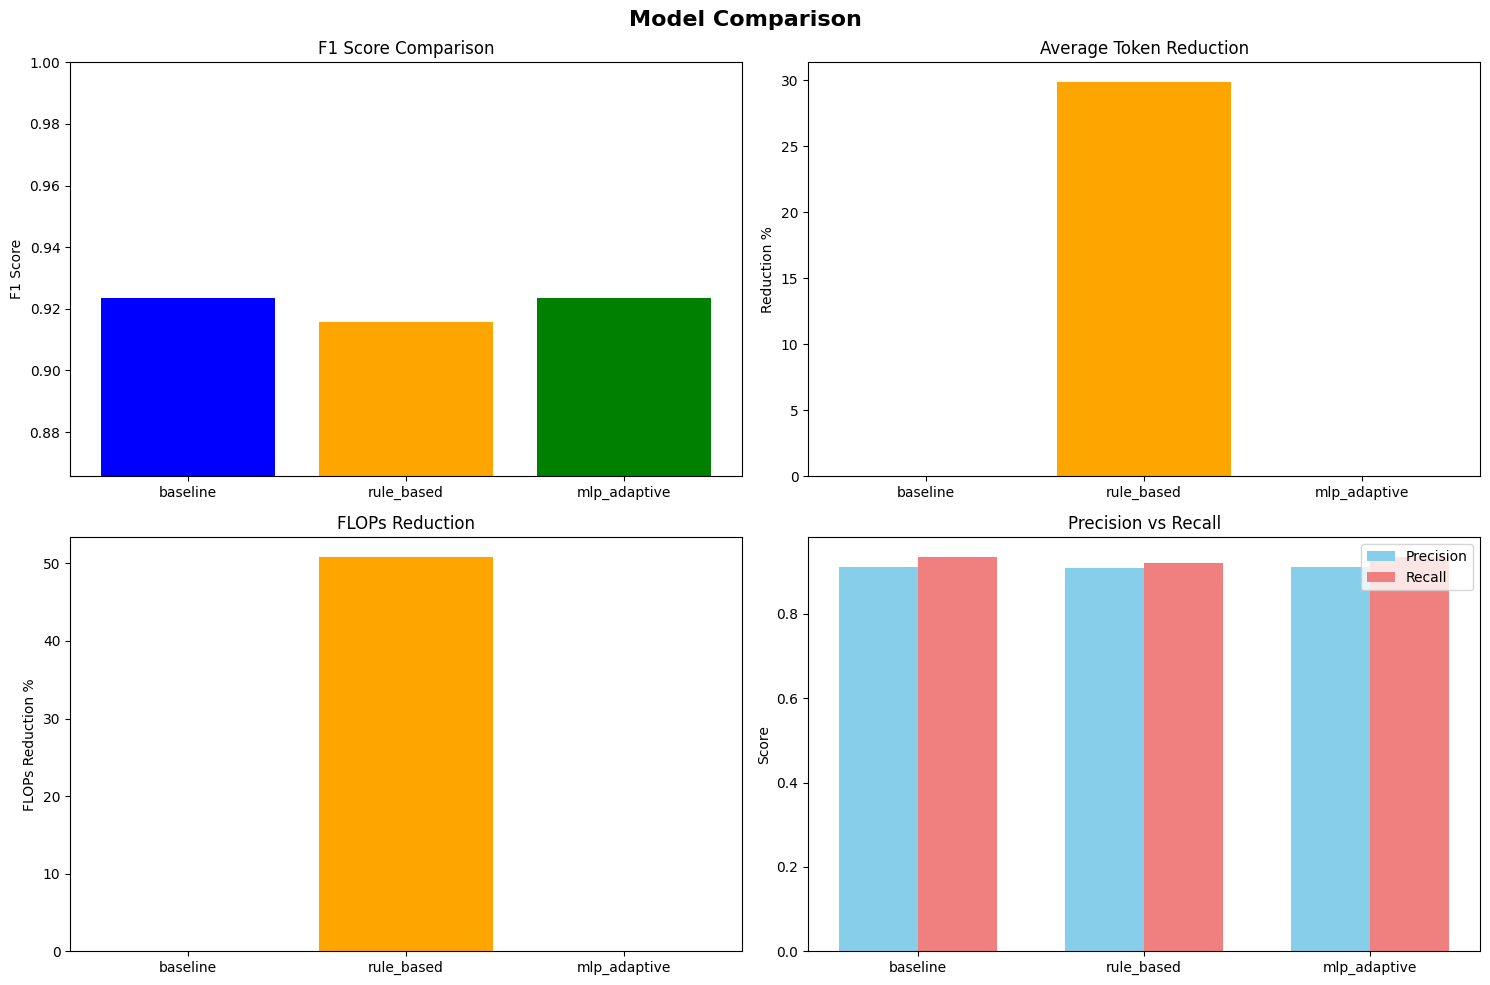

✓ Plot saved to /content/drive/MyDrive/AIML dataset/evaluation_results/ablation_lambda.png


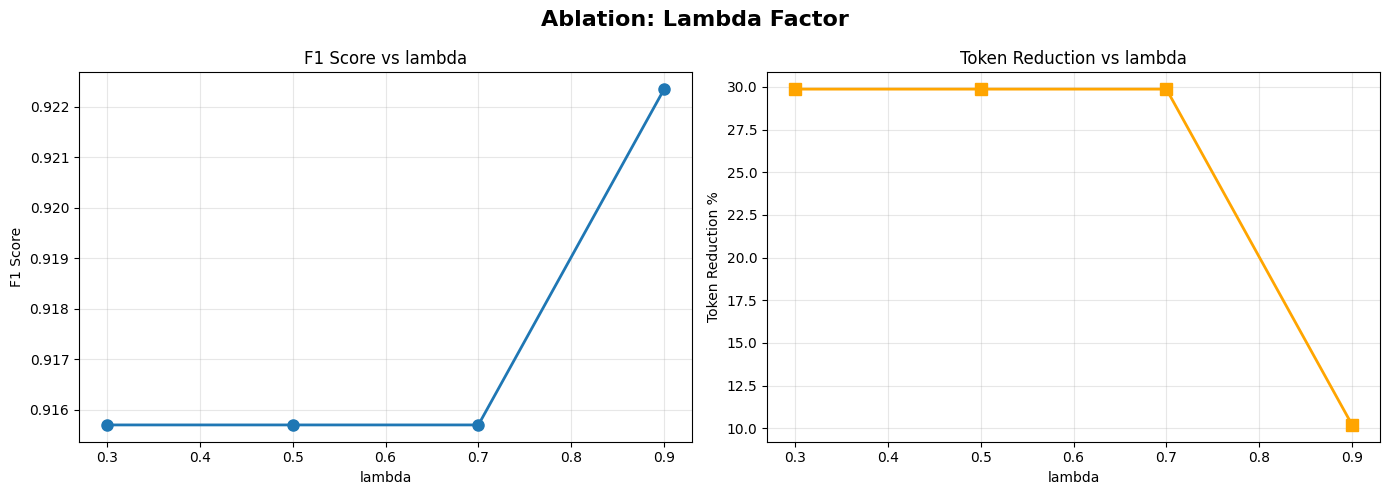

✓ Plot saved to /content/drive/MyDrive/AIML dataset/evaluation_results/ablation_keep_ratio.png


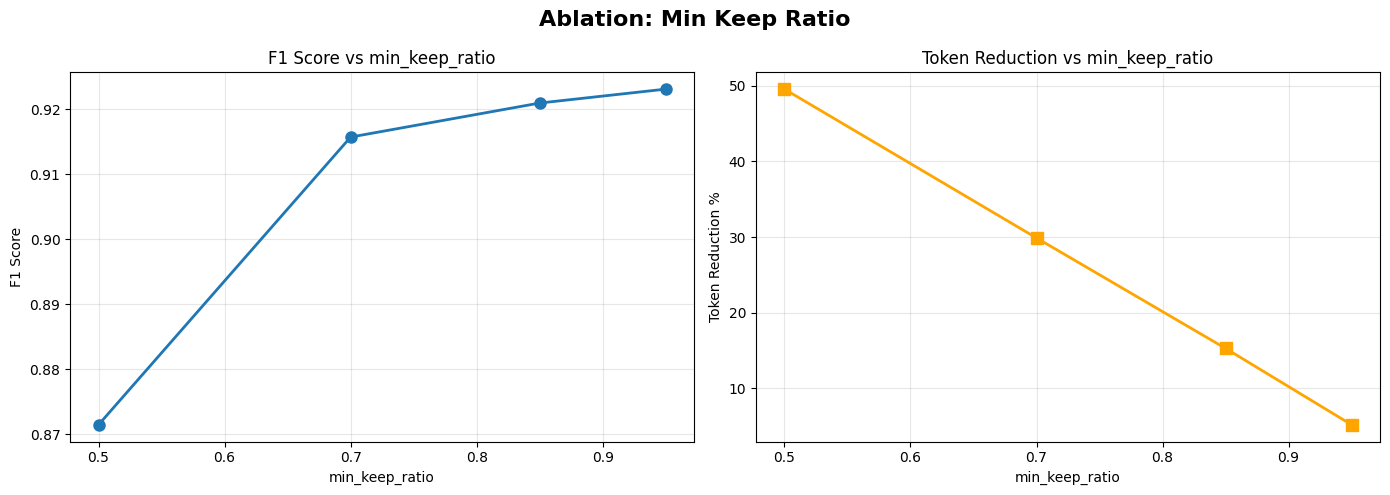


FINAL EVALUATION SUMMARY

MODEL PERFORMANCE:
       Model Precision Recall     F1 Avg Reduction % FLOPs Reduction % Theoretical Speedup
    baseline    0.9122 0.9351 0.9235             0.0               0.0               1.00x
  rule_based    0.9096 0.9219 0.9157            29.9              50.8               2.03x
mlp_adaptive    0.9122 0.9351 0.9235             0.0               0.0               1.00x


LATENCY COMPARISON:
       Model Mean (ms) Std (ms) Median (ms) Speedup
    baseline     14.42     0.48       14.46   1.00x
  rule_based     98.32    17.72       97.31   0.15x
mlp_adaptive    104.54    15.45      105.62   0.14x


KEY FINDINGS:
• Baseline F1: 0.9235
• MLP Adaptive F1: 0.9235 (Δ +0.0000)
• Token Reduction: 0.0%
• FLOPs Reduction: 0.0%
• Recovery Trigger Rate: 0.0%

✓ EVALUATION COMPLETE!
✓ All results saved to: /content/drive/MyDrive/AIML dataset/evaluation_results


NEXT STEPS:
1. Review saved results in evaluation_results folder
2. Analyze visualizations (PNG files

In [ ]:
# ============================================================================
# STEP 10: COMPREHENSIVE EVALUATION & EXPERIMENTS
# ============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import time
import json
from tqdm import tqdm
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================================
# 1. LOAD ALL THREE MODELS
# ============================================================================

def load_all_models():
    """
    Load baseline, rule-based, and MLP adaptive models

    FIXED: Load from directories (not .pt files)
    """
    print("\n" + "="*70)
    print("LOADING ALL MODELS")
    print("="*70 + "\n")

    from transformers import AutoModelForTokenClassification, AutoTokenizer
    import os

    MODEL_DIR = "/content/drive/MyDrive/AIML dataset/final_models"

    # 1. Baseline Model
    print("Loading Baseline Model...")
    baseline_path = f"{MODEL_DIR}/baseline_model"

    # Check if path exists
    if not os.path.exists(baseline_path):
        raise FileNotFoundError(f"Baseline model not found at {baseline_path}")

    # Load from HuggingFace format (directory with config.json, pytorch_model.bin, etc.)
    baseline_model = AutoModelForTokenClassification.from_pretrained(baseline_path)
    baseline_tokenizer = AutoTokenizer.from_pretrained(baseline_path)
    baseline_model.to(device)
    baseline_model.eval()
    print("✓ Baseline loaded\n")

    # 2. Rule-based Model
    print("Loading Rule-based Model...")
    rule_path = f"{MODEL_DIR}/rule_based"

    if not os.path.exists(rule_path):
        raise FileNotFoundError(f"Rule-based model not found at {rule_path}")

    rule_model = AutoModelForTokenClassification.from_pretrained(rule_path)
    rule_tokenizer = AutoTokenizer.from_pretrained(rule_path)
    rule_model.to(device)
    rule_model.eval()
    print("✓ Rule-based loaded\n")

    # 3. MLP Adaptive Model
    print("Loading MLP Adaptive Model...")
    mlp_path = f"{MODEL_DIR}/mlp_adaptive"

    if not os.path.exists(mlp_path):
        raise FileNotFoundError(f"MLP model not found at {mlp_path}")

    mlp_model = AutoModelForTokenClassification.from_pretrained(mlp_path)
    mlp_tokenizer = AutoTokenizer.from_pretrained(mlp_path)
    mlp_model.to(device)
    mlp_model.eval()

    # Load MLP Controller (separate .pt file)
    print("Loading MLP Controller...")
    mlp_controller = LearnedController(
        input_dim=2,
        hidden_dim=64
    ).to(device)

    controller_path = "/content/drive/MyDrive/AIML dataset/mlp_controller.pt"

    if not os.path.exists(controller_path):
        raise FileNotFoundError(f"MLP controller not found at {controller_path}")

    mlp_controller.load_state_dict(torch.load(controller_path))
    mlp_controller.eval()
    print("✓ MLP Controller loaded\n")

    print("="*70 + "\n")

    return {
        'baseline': {'model': baseline_model, 'tokenizer': baseline_tokenizer},
        'rule_based': {'model': rule_model, 'tokenizer': rule_tokenizer},
        'mlp_adaptive': {'model': mlp_model, 'tokenizer': mlp_tokenizer, 'controller': mlp_controller}
    }


# ============================================================================
# 2. LATENCY MEASUREMENT
# ============================================================================

def measure_inference_latency(model, dataloader, num_samples=100, mode='baseline',
                              controller=None, tokenizer=None):
    """
    Measure inference latency per sample

    Args:
        model: the model to evaluate
        dataloader: data loader
        num_samples: number of samples to measure
        mode: 'baseline', 'rule_based', or 'mlp_adaptive'
        controller: MLP controller (if using MLP mode)
        tokenizer: tokenizer (for adaptive modes)
    """
    model.eval()

    latencies = []
    sample_count = 0

    print(f"Measuring latency for {mode} ({num_samples} samples)...")

    for batch in tqdm(dataloader, desc=f"Latency {mode}"):
        if sample_count >= num_samples:
            break

        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            if sample_count >= num_samples:
                break

            input_ids = batch["input_ids"][i].to(device)
            attention_mask = batch["attention_mask"][i].to(device)

            # Synchronize before timing
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            start_time = time.time()

            # ============================================================
            # BASELINE MODE
            # ============================================================
            if mode == 'baseline':
                with torch.no_grad():
                    _ = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0)
                    )

            # ============================================================
            # RULE-BASED MODE
            # ============================================================
            elif mode == 'rule_based':
                entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

                with torch.no_grad():
                    outputs = model.bert(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0),
                        output_hidden_states=True,
                        return_dict=True
                    )
                    hidden_states = outputs.last_hidden_state.squeeze(0)
                    logits = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)

                keep_mask = controller_get_keep_mask(
                    input_ids.cpu(),
                    attention_mask.cpu(),
                    tokenizer,
                    entropy_scores,
                    logits.cpu().detach(),
                    lambda_factor=0.5,
                    min_keep_ratio=0.70
                )

                pruned_mask = attention_mask.clone()
                for j, keep in enumerate(keep_mask):
                    if keep == 0:
                        pruned_mask[j] = 0

                with torch.no_grad():
                    _ = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=pruned_mask.unsqueeze(0)
                    )

            # ============================================================
            # MLP ADAPTIVE MODE
            # ============================================================
            elif mode == 'mlp_adaptive':
                entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

                results = adaptive_inference_with_recovery(
                    model=model,
                    controller=controller,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    entropy_scores=entropy_scores,
                    tokenizer=tokenizer,
                    use_mlp=True,
                    enable_recovery=True
                )

            # Synchronize after inference
            if torch.cuda.is_available():
                torch.cuda.synchronize()

            end_time = time.time()
            latencies.append((end_time - start_time) * 1000)  # Convert to ms

            sample_count += 1

    return {
        'mean_ms': np.mean(latencies),
        'std_ms': np.std(latencies),
        'median_ms': np.median(latencies),
        'min_ms': np.min(latencies),
        'max_ms': np.max(latencies),
        'all_latencies': latencies
    }


# ============================================================================
# 3. FLOPS ESTIMATION
# ============================================================================

def estimate_flops_reduction(tokens_original, tokens_kept, model_hidden_size=768):
    """
    Estimate FLOPs reduction from token pruning

    Simplified calculation:
    - Self-attention: O(seq_len^2 * hidden_dim)
    - Feed-forward: O(seq_len * hidden_dim * ffn_dim)

    Approximate total FLOPs for transformer layer ≈ seq_len^2 * hidden_dim
    """

    # Original FLOPs (proportional to seq_len^2)
    original_flops = tokens_original ** 2 * model_hidden_size

    # Pruned FLOPs
    pruned_flops = tokens_kept ** 2 * model_hidden_size

    # Reduction percentage
    reduction_pct = 100 * (original_flops - pruned_flops) / original_flops

    return {
        'original_flops': original_flops,
        'pruned_flops': pruned_flops,
        'reduction_pct': reduction_pct,
        'speedup_theoretical': original_flops / pruned_flops if pruned_flops > 0 else 1.0
    }


# ============================================================================
# 4. COMPREHENSIVE MODEL EVALUATION
# ============================================================================

def evaluate_model_comprehensive(
    model,
    dataloader,
    tokenizer,
    mode='baseline',
    controller=None,
    max_samples=None,
    lambda_factor=0.5,
    min_keep_ratio=0.70,
    enable_recovery=True
):
    """
    Comprehensive evaluation with all metrics

    Returns:
        - Precision, Recall, F1 (entity-level)
        - Token reduction statistics
        - Latency measurements
        - FLOPs estimation
        - Recovery statistics (if applicable)
    """

    model.eval()

    all_true_labels = []
    all_pred_labels = []

    token_stats = []
    flops_stats = []
    recovery_stats = {
        'total_samples': 0,
        'recovery_triggered': 0,
        'tokens_recovered': 0,
        'conf_improvements': []
    }

    sample_count = 0

    print(f"\n{'='*70}")
    print(f"EVALUATING: {mode.upper()}")
    print(f"{'='*70}\n")

    for batch in tqdm(dataloader, desc=f"Eval {mode}"):
        if max_samples and sample_count >= max_samples:
            break

        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            if max_samples and sample_count >= max_samples:
                break

            input_ids = batch["input_ids"][i].to(device)
            attention_mask = batch["attention_mask"][i].to(device)
            labels = batch["labels"][i]

            n_original = attention_mask.sum().item()

            # ============================================================
            # BASELINE INFERENCE
            # ============================================================
            if mode == 'baseline':
                with torch.no_grad():
                    outputs = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0)
                    )
                    preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

                token_stats.append({
                    'tokens_original': n_original,
                    'tokens_kept': n_original,
                    'reduction_pct': 0.0
                })

                flops = estimate_flops_reduction(n_original, n_original)
                flops_stats.append(flops)

            # ============================================================
            # RULE-BASED INFERENCE
            # ============================================================
            elif mode == 'rule_based':
                entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

                with torch.no_grad():
                    outputs = model.bert(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0),
                        output_hidden_states=True,
                        return_dict=True
                    )
                    hidden_states = outputs.last_hidden_state.squeeze(0)
                    logits = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)

                keep_mask = controller_get_keep_mask(
                    input_ids.cpu(),
                    attention_mask.cpu(),
                    tokenizer,
                    entropy_scores,
                    logits.cpu().detach(),
                    lambda_factor=lambda_factor,
                    min_keep_ratio=min_keep_ratio
                )

                pruned_mask = attention_mask.clone()
                for j, keep in enumerate(keep_mask):
                    if keep == 0:
                        pruned_mask[j] = 0

                with torch.no_grad():
                    outputs_pruned = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=pruned_mask.unsqueeze(0)
                    )
                    preds = outputs_pruned.logits.squeeze(0).argmax(dim=-1).cpu()

                n_kept = pruned_mask.sum().item()
                reduction = 100 * (n_original - n_kept) / n_original

                token_stats.append({
                    'tokens_original': n_original,
                    'tokens_kept': n_kept,
                    'reduction_pct': reduction
                })

                flops = estimate_flops_reduction(n_original, n_kept)
                flops_stats.append(flops)

            # ============================================================
            # MLP ADAPTIVE INFERENCE
            # ============================================================
            elif mode == 'mlp_adaptive':
                entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

                results = adaptive_inference_with_recovery(
                    model=model,
                    controller=controller,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    entropy_scores=entropy_scores,
                    tokenizer=tokenizer,
                    labels=labels,
                    use_mlp=True,
                    enable_recovery=enable_recovery
                )

                preds = results['predictions']

                token_stats.append({
                    'tokens_original': results['tokens_original'],
                    'tokens_kept': results['tokens_final'],
                    'reduction_pct': results['reduction_pct']
                })

                flops = estimate_flops_reduction(
                    results['tokens_original'],
                    results['tokens_final']
                )
                flops_stats.append(flops)

                # Recovery stats
                if enable_recovery and results['recovery_triggered']:
                    recovery_stats['recovery_triggered'] += 1
                    recovery_stats['tokens_recovered'] += results['tokens_recovered']
                    conf_improvement = results['conf_final'] - results['conf_pruned']
                    recovery_stats['conf_improvements'].append(conf_improvement)

            # ============================================================
            # COLLECT LABELS
            # ============================================================
            seq_true = []
            seq_pred = []

            for j in range(len(labels)):
                if attention_mask[j] == 1 and labels[j] != -100:
                    seq_true.append(id2label[labels[j].item()])
                    seq_pred.append(id2label[preds[j].item()])

            if len(seq_true) > 0:
                all_true_labels.append(seq_true)
                all_pred_labels.append(seq_pred)

            sample_count += 1
            recovery_stats['total_samples'] = sample_count

    # ============================================================
    # COMPUTE METRICS
    # ============================================================

    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)

    token_df = pd.DataFrame(token_stats)
    flops_df = pd.DataFrame(flops_stats)

    # Recovery rate
    if enable_recovery and mode == 'mlp_adaptive':
        recovery_stats['recovery_rate'] = recovery_stats['recovery_triggered'] / sample_count
        if len(recovery_stats['conf_improvements']) > 0:
            recovery_stats['avg_conf_improvement'] = np.mean(recovery_stats['conf_improvements'])

    # Print results
    print(f"\n{'='*70}")
    print(f"RESULTS: {mode.upper()}")
    print(f"{'='*70}")
    print(f"Samples:              {sample_count}")
    print(f"Precision:            {precision:.4f}")
    print(f"Recall:               {recall:.4f}")
    print(f"F1 Score:             {f1:.4f}")
    print(f"\nToken Statistics:")
    print(f"Avg tokens original:  {token_df['tokens_original'].mean():.1f}")
    print(f"Avg tokens kept:      {token_df['tokens_kept'].mean():.1f}")
    print(f"Avg reduction:        {token_df['reduction_pct'].mean():.1f}%")
    print(f"\nFLOPs Statistics:")
    print(f"Avg FLOPs reduction:  {flops_df['reduction_pct'].mean():.1f}%")
    print(f"Theoretical speedup:  {flops_df['speedup_theoretical'].mean():.2f}x")

    if enable_recovery and mode == 'mlp_adaptive':
        print(f"\nRecovery Statistics:")
        print(f"Triggered:            {recovery_stats['recovery_triggered']}/{sample_count} "
              f"({recovery_stats['recovery_rate']*100:.1f}%)")
        print(f"Tokens recovered:     {recovery_stats['tokens_recovered']}")
        if 'avg_conf_improvement' in recovery_stats:
            print(f"Avg conf improvement: {recovery_stats['avg_conf_improvement']:.4f}")

    print(f"{'='*70}\n")

    return {
        'mode': mode,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'token_stats': token_df,
        'flops_stats': flops_df,
        'recovery_stats': recovery_stats,
        'classification_report': classification_report(all_true_labels, all_pred_labels)
    }


# ============================================================================
# 5. COMPARE ALL MODELS
# ============================================================================

def compare_all_models(models_dict, dataloader, max_samples=200):
    """
    Compare baseline, rule-based, and MLP adaptive models
    """

    print("\n" + "="*70)
    print("COMPREHENSIVE MODEL COMPARISON")
    print("="*70 + "\n")

    results = {}

    # Evaluate each model
    for model_name, model_info in models_dict.items():

        if model_name == 'baseline':
            results[model_name] = evaluate_model_comprehensive(
                model=model_info['model'],
                dataloader=dataloader,
                tokenizer=model_info['tokenizer'],
                mode='baseline',
                max_samples=max_samples
            )

        elif model_name == 'rule_based':
            results[model_name] = evaluate_model_comprehensive(
                model=model_info['model'],
                dataloader=dataloader,
                tokenizer=model_info['tokenizer'],
                mode='rule_based',
                max_samples=max_samples,
                lambda_factor=0.5,
                min_keep_ratio=0.70
            )

        elif model_name == 'mlp_adaptive':
            results[model_name] = evaluate_model_comprehensive(
                model=model_info['model'],
                dataloader=dataloader,
                tokenizer=model_info['tokenizer'],
                mode='mlp_adaptive',
                controller=model_info['controller'],
                max_samples=max_samples,
                enable_recovery=True
            )

    # ============================================================
    # COMPARISON SUMMARY
    # ============================================================

    print("\n" + "="*70)
    print("COMPARISON SUMMARY")
    print("="*70 + "\n")

    comparison_data = []

    for model_name, result in results.items():
        comparison_data.append({
            'Model': model_name,
            'Precision': f"{result['precision']:.4f}",
            'Recall': f"{result['recall']:.4f}",
            'F1': f"{result['f1']:.4f}",
            'Avg Reduction %': f"{result['token_stats']['reduction_pct'].mean():.1f}",
            'FLOPs Reduction %': f"{result['flops_stats']['reduction_pct'].mean():.1f}",
            'Theoretical Speedup': f"{result['flops_stats']['speedup_theoretical'].mean():.2f}x"
        })

    comparison_df = pd.DataFrame(comparison_data)
    print(comparison_df.to_string(index=False))
    print("\n" + "="*70 + "\n")

    return results, comparison_df


# ============================================================================
# 6. LATENCY COMPARISON
# ============================================================================

def compare_latencies(models_dict, dataloader, num_samples=100):
    """
    Compare inference latencies across all models
    """

    print("\n" + "="*70)
    print("LATENCY COMPARISON")
    print("="*70 + "\n")

    latency_results = {}

    # Baseline
    print("Measuring baseline latency...")
    latency_results['baseline'] = measure_inference_latency(
        model=models_dict['baseline']['model'],
        dataloader=dataloader,
        num_samples=num_samples,
        mode='baseline'
    )

    # Rule-based
    print("\nMeasuring rule-based latency...")
    latency_results['rule_based'] = measure_inference_latency(
        model=models_dict['rule_based']['model'],
        dataloader=dataloader,
        num_samples=num_samples,
        mode='rule_based',
        tokenizer=models_dict['rule_based']['tokenizer']
    )

    # MLP Adaptive
    print("\nMeasuring MLP adaptive latency...")
    latency_results['mlp_adaptive'] = measure_inference_latency(
        model=models_dict['mlp_adaptive']['model'],
        dataloader=dataloader,
        num_samples=num_samples,
        mode='mlp_adaptive',
        controller=models_dict['mlp_adaptive']['controller'],
        tokenizer=models_dict['mlp_adaptive']['tokenizer']
    )

    # Print comparison
    print("\n" + "="*70)
    print("LATENCY RESULTS")
    print("="*70 + "\n")

    latency_data = []
    baseline_mean = latency_results['baseline']['mean_ms']

    for model_name, stats in latency_results.items():
        speedup = baseline_mean / stats['mean_ms']
        latency_data.append({
            'Model': model_name,
            'Mean (ms)': f"{stats['mean_ms']:.2f}",
            'Std (ms)': f"{stats['std_ms']:.2f}",
            'Median (ms)': f"{stats['median_ms']:.2f}",
            'Speedup': f"{speedup:.2f}x"
        })

    latency_df = pd.DataFrame(latency_data)
    print(latency_df.to_string(index=False))
    print("\n" + "="*70 + "\n")

    return latency_results, latency_df


# ============================================================================
# 7. ABLATION STUDIES
# ============================================================================

def ablation_lambda_factor(model, controller, dataloader, tokenizer, max_samples=200):
    """
    Ablation: Effect of lambda_factor (pruning aggressiveness)
    """

    print("\n" + "="*70)
    print("ABLATION: LAMBDA FACTOR (Pruning Aggressiveness)")
    print("="*70 + "\n")

    lambda_values = [0.3, 0.5, 0.7, 0.9]
    results = []

    for lambda_val in lambda_values:
        print(f"\nTesting lambda = {lambda_val}...")

        result = evaluate_model_comprehensive(
            model=model,
            dataloader=dataloader,
            tokenizer=tokenizer,
            mode='rule_based',
            max_samples=max_samples,
            lambda_factor=lambda_val,
            min_keep_ratio=0.70
        )

        results.append({
            'lambda': lambda_val,
            'f1': result['f1'],
            'precision': result['precision'],
            'recall': result['recall'],
            'avg_reduction': result['token_stats']['reduction_pct'].mean()
        })

    ablation_df = pd.DataFrame(results)

    print("\n" + "="*70)
    print("LAMBDA FACTOR ABLATION RESULTS")
    print("="*70 + "\n")
    print(ablation_df.to_string(index=False))
    print("\n" + "="*70 + "\n")

    return ablation_df


def ablation_min_keep_ratio(model, controller, dataloader, tokenizer, max_samples=200):
    """
    Ablation: Effect of min_keep_ratio
    """

    print("\n" + "="*70)
    print("ABLATION: MIN KEEP RATIO")
    print("="*70 + "\n")

    keep_ratios = [0.50, 0.70, 0.85, 0.95]
    results = []

    for ratio in keep_ratios:
        print(f"\nTesting min_keep_ratio = {ratio}...")

        result = evaluate_model_comprehensive(
            model=model,
            dataloader=dataloader,
            tokenizer=tokenizer,
            mode='rule_based',
            max_samples=max_samples,
            lambda_factor=0.5,
            min_keep_ratio=ratio
        )

        results.append({
            'min_keep_ratio': ratio,
            'f1': result['f1'],
            'precision': result['precision'],
            'recall': result['recall'],
            'avg_reduction': result['token_stats']['reduction_pct'].mean()
        })

    ablation_df = pd.DataFrame(results)

    print("\n" + "="*70)
    print("MIN KEEP RATIO ABLATION RESULTS")
    print("="*70 + "\n")
    print(ablation_df.to_string(index=False))
    print("\n" + "="*70 + "\n")

    return ablation_df


def ablation_recovery_enabled(model, controller, dataloader, tokenizer, max_samples=200):
    """
    Ablation: Effect of recovery mechanism
    """

    print("\n" + "="*70)
    print("ABLATION: RECOVERY MECHANISM")
    print("="*70 + "\n")

    # Without recovery
    print("Testing WITHOUT recovery...")
    result_no_recovery = evaluate_model_comprehensive(
        model=model,
        dataloader=dataloader,
        tokenizer=tokenizer,
        mode='mlp_adaptive',
        controller=controller,
        max_samples=max_samples,
        enable_recovery=False
    )

    # With recovery
    print("\nTesting WITH recovery...")
    result_with_recovery = evaluate_model_comprehensive(
        model=model,
        dataloader=dataloader,
        tokenizer=tokenizer,
        mode='mlp_adaptive',
        controller=controller,
        max_samples=max_samples,
        enable_recovery=True
    )

    # Compare
    print("\n" + "="*70)
    print("RECOVERY ABLATION RESULTS")
    print("="*70 + "\n")

    comparison = pd.DataFrame([
        {
            'Recovery': 'Disabled',
            'F1': f"{result_no_recovery['f1']:.4f}",
            'Precision': f"{result_no_recovery['precision']:.4f}",
            'Recall': f"{result_no_recovery['recall']:.4f}",
            'Avg Reduction %': f"{result_no_recovery['token_stats']['reduction_pct'].mean():.1f}"
        },
        {
            'Recovery': 'Enabled',
            'F1': f"{result_with_recovery['f1']:.4f}",
            'Precision': f"{result_with_recovery['precision']:.4f}",
            'Recall': f"{result_with_recovery['recall']:.4f}",
            'Avg Reduction %': f"{result_with_recovery['token_stats']['reduction_pct'].mean():.1f}"
        }
    ])

    print(comparison.to_string(index=False))

    f1_improvement = result_with_recovery['f1'] - result_no_recovery['f1']
    print(f"\nF1 Improvement: {f1_improvement:+.4f}")
    print("="*70 + "\n")

    return comparison


# ============================================================================
# 8. SAVE ALL RESULTS
# ============================================================================

def save_evaluation_results(comparison_results, latency_results, ablation_results, save_dir):
    """
    Save all evaluation results to JSON and CSV files
    """

    print(f"\nSaving results to {save_dir}...")

    import os
    os.makedirs(save_dir, exist_ok=True)

    # 1. Save comparison results
    comparison_json = {}
    for model_name, result in comparison_results.items():
        comparison_json[model_name] = {
            'precision': float(result['precision']),
            'recall': float(result['recall']),
            'f1': float(result['f1']),
            'avg_token_reduction': float(result['token_stats']['reduction_pct'].mean()),
            'avg_flops_reduction': float(result['flops_stats']['reduction_pct'].mean()),
            'theoretical_speedup': float(result['flops_stats']['speedup_theoretical'].mean())
        }

        if 'recovery_stats' in result and result['recovery_stats']['total_samples'] > 0:
            rec = result['recovery_stats']
            comparison_json[model_name]['recovery_rate'] = float(rec.get('recovery_rate', 0))
            comparison_json[model_name]['tokens_recovered'] = int(rec.get('tokens_recovered', 0))

    with open(f"{save_dir}/comparison_results.json", 'w') as f:
        json.dump(comparison_json, f, indent=4)

    # 2. Save latency results
    latency_json = {}
    for model_name, stats in latency_results.items():
        latency_json[model_name] = {
            'mean_ms': float(stats['mean_ms']),
            'std_ms': float(stats['std_ms']),
            'median_ms': float(stats['median_ms'])
        }

    with open(f"{save_dir}/latency_results.json", 'w') as f:
        json.dump(latency_json, f, indent=4)

    # 3. Save ablation results
    for ablation_name, ablation_df in ablation_results.items():
        ablation_df.to_csv(f"{save_dir}/ablation_{ablation_name}.csv", index=False)

    print(f"✓ All results saved to {save_dir}")


# ============================================================================
# 9. VISUALIZATION FUNCTIONS
# ============================================================================

def plot_model_comparison(comparison_results, save_path=None):
    """
    Create visualization comparing all models
    """

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Model Comparison', fontsize=16, fontweight='bold')

    models = list(comparison_results.keys())

    # F1 Scores
    f1_scores = [comparison_results[m]['f1'] for m in models]
    axes[0, 0].bar(models, f1_scores, color=['blue', 'orange', 'green'])
    axes[0, 0].set_ylabel('F1 Score')
    axes[0, 0].set_title('F1 Score Comparison')
    axes[0, 0].set_ylim([min(f1_scores) - 0.05, 1.0])

    # Token Reduction
    reductions = [comparison_results[m]['token_stats']['reduction_pct'].mean() for m in models]
    axes[0, 1].bar(models, reductions, color=['blue', 'orange', 'green'])
    axes[0, 1].set_ylabel('Reduction %')
    axes[0, 1].set_title('Average Token Reduction')

    # FLOPs Reduction
    flops_red = [comparison_results[m]['flops_stats']['reduction_pct'].mean() for m in models]
    axes[1, 0].bar(models, flops_red, color=['blue', 'orange', 'green'])
    axes[1, 0].set_ylabel('FLOPs Reduction %')
    axes[1, 0].set_title('FLOPs Reduction')

    # Precision-Recall
    precisions = [comparison_results[m]['precision'] for m in models]
    recalls = [comparison_results[m]['recall'] for m in models]

    x = np.arange(len(models))
    width = 0.35

    axes[1, 1].bar(x - width/2, precisions, width, label='Precision', color='skyblue')
    axes[1, 1].bar(x + width/2, recalls, width, label='Recall', color='lightcoral')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Precision vs Recall')
    axes[1, 1].set_xticks(x)
    axes[1, 1].set_xticklabels(models)
    axes[1, 1].legend()

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to {save_path}")

    plt.show()


def plot_ablation_results(ablation_df, x_col, title, save_path=None):
    """
    Plot ablation study results
    """

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # F1 vs Parameter
    axes[0].plot(ablation_df[x_col], ablation_df['f1'], marker='o', linewidth=2, markersize=8)
    axes[0].set_xlabel(x_col)
    axes[0].set_ylabel('F1 Score')
    axes[0].set_title(f'F1 Score vs {x_col}')
    axes[0].grid(True, alpha=0.3)

    # Reduction vs Parameter
    axes[1].plot(ablation_df[x_col], ablation_df['avg_reduction'],
                marker='s', linewidth=2, markersize=8, color='orange')
    axes[1].set_xlabel(x_col)
    axes[1].set_ylabel('Token Reduction %')
    axes[1].set_title(f'Token Reduction vs {x_col}')
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Plot saved to {save_path}")

    plt.show()


# ============================================================================
# 10. MAIN EXECUTION
# ============================================================================

def run_complete_evaluation(max_samples=200):
    """
    Run complete evaluation pipeline
    """

    print("\n" + "="*70)
    print("STEP 10: COMPLETE EVALUATION & EXPERIMENTS")
    print("="*70 + "\n")

    # Load all models
    models_dict = load_all_models()

    # ========================================================================
    # EXPERIMENT 1: Model Comparison
    # ========================================================================
    print("\n>>> EXPERIMENT 1: MODEL COMPARISON")
    comparison_results, comparison_df = compare_all_models(
        models_dict,
        dev_loader,
        max_samples=max_samples
    )

    # ========================================================================
    # EXPERIMENT 2: Latency Comparison
    # ========================================================================
    print("\n>>> EXPERIMENT 2: LATENCY COMPARISON")
    latency_results, latency_df = compare_latencies(
        models_dict,
        dev_loader,
        num_samples=100
    )

    # ========================================================================
    # EXPERIMENT 3: Ablation Studies
    # ========================================================================
    print("\n>>> EXPERIMENT 3: ABLATION STUDIES")

    ablation_results = {}

    # Lambda factor ablation (rule-based model)
    ablation_results['lambda_factor'] = ablation_lambda_factor(
        models_dict['rule_based']['model'],
        None,
        dev_loader,
        models_dict['rule_based']['tokenizer'],
        max_samples=max_samples
    )

    # Min keep ratio ablation (rule-based model)
    ablation_results['min_keep_ratio'] = ablation_min_keep_ratio(
        models_dict['rule_based']['model'],
        None,
        dev_loader,
        models_dict['rule_based']['tokenizer'],
        max_samples=max_samples
    )

    # Recovery mechanism ablation (MLP model)
    ablation_results['recovery'] = ablation_recovery_enabled(
        models_dict['mlp_adaptive']['model'],
        models_dict['mlp_adaptive']['controller'],
        dev_loader,
        models_dict['mlp_adaptive']['tokenizer'],
        max_samples=max_samples
    )

    # ========================================================================
    # SAVE ALL RESULTS
    # ========================================================================
    save_dir = "/content/drive/MyDrive/AIML dataset/evaluation_results"
    save_evaluation_results(
        comparison_results,
        latency_results,
        ablation_results,
        save_dir
    )

    # ========================================================================
    # GENERATE VISUALIZATIONS
    # ========================================================================
    print("\n>>> GENERATING VISUALIZATIONS")

    plot_model_comparison(
        comparison_results,
        save_path=f"{save_dir}/model_comparison.png"
    )

    plot_ablation_results(
        ablation_results['lambda_factor'],
        'lambda',
        'Ablation: Lambda Factor',
        save_path=f"{save_dir}/ablation_lambda.png"
    )

    plot_ablation_results(
        ablation_results['min_keep_ratio'],
        'min_keep_ratio',
        'Ablation: Min Keep Ratio',
        save_path=f"{save_dir}/ablation_keep_ratio.png"
    )

    # ========================================================================
    # FINAL SUMMARY
    # ========================================================================
    print("\n" + "="*70)
    print("FINAL EVALUATION SUMMARY")
    print("="*70 + "\n")

    print("MODEL PERFORMANCE:")
    print(comparison_df.to_string(index=False))

    print("\n\nLATENCY COMPARISON:")
    print(latency_df.to_string(index=False))

    print("\n\nKEY FINDINGS:")

    baseline_f1 = comparison_results['baseline']['f1']
    mlp_f1 = comparison_results['mlp_adaptive']['f1']
    mlp_reduction = comparison_results['mlp_adaptive']['token_stats']['reduction_pct'].mean()

    print(f"• Baseline F1: {baseline_f1:.4f}")
    print(f"• MLP Adaptive F1: {mlp_f1:.4f} (Δ {mlp_f1 - baseline_f1:+.4f})")
    print(f"• Token Reduction: {mlp_reduction:.1f}%")
    print(f"• FLOPs Reduction: {comparison_results['mlp_adaptive']['flops_stats']['reduction_pct'].mean():.1f}%")

    if 'recovery_rate' in comparison_results['mlp_adaptive']['recovery_stats']:
        rec_rate = comparison_results['mlp_adaptive']['recovery_stats']['recovery_rate']
        print(f"• Recovery Trigger Rate: {rec_rate*100:.1f}%")

    print("\n" + "="*70)
    print("✓ EVALUATION COMPLETE!")
    print(f"✓ All results saved to: {save_dir}")
    print("="*70 + "\n")

    return {
        'comparison_results': comparison_results,
        'latency_results': latency_results,
        'ablation_results': ablation_results,
        'save_dir': save_dir
    }


# ============================================================================
# RUN EVERYTHING
# ============================================================================

if __name__ == "__main__":
    # Run complete evaluation with 200 samples
    all_results = run_complete_evaluation(max_samples=200)

    print("\n" + "="*70)
    print("NEXT STEPS:")
    print("="*70)
    print("1. Review saved results in evaluation_results folder")
    print("2. Analyze visualizations (PNG files)")
    print("3. Compare JSON files for detailed metrics")
    print("4. Run with more samples for final paper results")
    print("="*70 + "\n")

Step 11: Error Analysis & Fairness Check


STEP 11: ERROR ANALYSIS & FAIRNESS CHECK


LOADING ALL MODELS

Loading Baseline Model...
✓ Baseline loaded

Loading Rule-based Model...
✓ Rule-based loaded

Loading MLP Adaptive Model...
Loading MLP Controller...
✓ MLP Controller loaded



STEP 11: COMPREHENSIVE ERROR ANALYSIS

>>> ANALYSIS 1: CLASS-WISE PERFORMANCE

Analyzing baseline...



Class-wise Metrics for baseline:
     Class  Precision   Recall  F1-Score  Support
B-Chemical   0.941592 0.944143  0.942866   6642.0
 B-Disease   0.875189 0.923092  0.898503   5006.0
         O   0.979272 0.970959  0.975098  34400.0

Entity Type Metrics for baseline:
Entity Type  Precision   Recall  F1-Score  Support
   Chemical   0.944143 0.944143  0.944143     6642
    Disease   0.923092 0.923092  0.923092     5006
          O   0.970959 0.970959  0.970959    34400

----------------------------------------------------------------------

Analyzing rule_based...



Class-wise Metrics for rule_based:
     Class  Precision   Recall  F1-Score  Support
B-Chemical   0.936360 0.934809  0.935584   6642.0
 B-Disease   0.875338 0.904714  0.889784   5006.0
         O   0.975294 0.970843  0.973064  34400.0

Entity Type Metrics for rule_based:
Entity Type  Precision   Recall  F1-Score  Support
   Chemical   0.934809 0.934809  0.934809     6642
    Disease   0.904714 0.904714  0.904714     5006
          O   0.970843 0.970843  0.970843    34400

----------------------------------------------------------------------

Analyzing mlp_adaptive...



Class-wise Metrics for mlp_adaptive:
     Class  Precision   Recall  F1-Score  Support
B-Chemical   0.941592 0.944143  0.942866   6642.0
 B-Disease   0.875189 0.923092  0.898503   5006.0
         O   0.979272 0.970959  0.975098  34400.0

Entity Type Metrics for mlp_adaptive:
Entity Type  Precision   Recall  F1-Score  Support
   Chemical   0.944143 0.944143  0.944143     6642
    Disease   0.923092 0.923092  0.923092     5006
          O   0.970959 0.970959  0.970959    34400

----------------------------------------------------------------------


>>> ANALYSIS 2: PRUNING ERROR ANALYSIS

Analyzing rule-based pruning...

Analyzing pruned tokens (rule_based)...


Pruning Analysis:  40%|████      | 50/125 [00:20<00:31,  2.42it/s]



PRUNING ANALYSIS

Total Tokens:           46048
Pruned Tokens:          13753 (29.9%)
Kept Tokens:            32295

Entity Token Analysis:
Entity Tokens Pruned:   68
Entity Tokens Kept:     11580
Entity Retention Rate:  99.4%

Entropy Statistics:
Pruned tokens entropy:  5.545 ± 0.000
Kept tokens entropy:    5.545 ± 0.000

Pruned Tokens by Label:
  O              : 13685 / 34400 (39.8% pruned)
  B-Disease      :    35 /  5006 (0.7% pruned)
  B-Chemical     :    33 /  6642 (0.5% pruned)

Top 10 Incorrectly Pruned Entity Tokens:
 1. Token: 'pine           ' | True: B-Chemical      | Pred: B-Chemical      | Entropy: 5.545
 2. Token: 's              ' | True: B-Chemical      | Pred: B-Chemical      | Entropy: 5.545
 3. Token: 'imp            ' | True: B-Disease       | Pred: B-Disease       | Entropy: 5.545
 4. Token: '##ic           ' | True: B-Disease       | Pred: B-Disease       | Entropy: 5.545
 5. Token: '##ly           ' | True: B-Disease       | Pred: B-Disease       | Entropy: 5.

Pruning Analysis:  40%|████      | 50/125 [00:20<00:30,  2.44it/s]



PRUNING ANALYSIS

Total Tokens:           46048
Pruned Tokens:          0 (0.0%)
Kept Tokens:            46048

Entity Token Analysis:
Entity Tokens Pruned:   0
Entity Tokens Kept:     11648
Entity Retention Rate:  100.0%

Entropy Statistics:
Kept tokens entropy:    5.545 ± 0.000

Pruned Tokens by Label:

Top 10 Incorrectly Pruned Entity Tokens:


>>> ANALYSIS 3: FAIRNESS ANALYSIS

Fairness analysis for baseline...

Counting entity frequencies...
Total unique entities:  2
Rare entities:          1 (≤ 13616.75 occurrences)
Frequent entities:      1 (> 13616.75 occurrences)

Evaluating on rare vs frequent entities...


Fairness Analysis:  40%|████      | 50/125 [00:04<00:07, 10.65it/s]



BASELINE - Fairness Results:

FAIRNESS ANALYSIS - RARE vs FREQUENT ENTITIES

Rare Entities:
  Accuracy:  0.9231
  Support:   5006

Frequent Entities:
  Accuracy:  0.9441
  Support:   6642

Performance Gap: +0.0211
  (Positive = model favors frequent entities)

Fairness analysis for rule_based...

Counting entity frequencies...
Total unique entities:  2
Rare entities:          1 (≤ 13616.75 occurrences)
Frequent entities:      1 (> 13616.75 occurrences)

Evaluating on rare vs frequent entities...


Fairness Analysis:  40%|████      | 50/125 [00:23<00:34,  2.17it/s]



RULE_BASED - Fairness Results:

FAIRNESS ANALYSIS - RARE vs FREQUENT ENTITIES

Rare Entities:
  Accuracy:  0.9047
  Support:   5006

Frequent Entities:
  Accuracy:  0.9348
  Support:   6642

Performance Gap: +0.0301
  (Positive = model favors frequent entities)

Fairness analysis for mlp_adaptive...

Counting entity frequencies...
Total unique entities:  2
Rare entities:          1 (≤ 13616.75 occurrences)
Frequent entities:      1 (> 13616.75 occurrences)

Evaluating on rare vs frequent entities...


Fairness Analysis:  40%|████      | 50/125 [00:25<00:37,  2.00it/s]



MLP_ADAPTIVE - Fairness Results:

FAIRNESS ANALYSIS - RARE vs FREQUENT ENTITIES

Rare Entities:
  Accuracy:  0.9231
  Support:   5006

Frequent Entities:
  Accuracy:  0.9441
  Support:   6642

Performance Gap: +0.0211
  (Positive = model favors frequent entities)


>>> ANALYSIS 4: CONFUSION MATRICES

Generating confusion matrix for baseline...
✓ Confusion matrix saved to /content/drive/MyDrive/AIML dataset/error_analysis/confusion_matrix_baseline.png


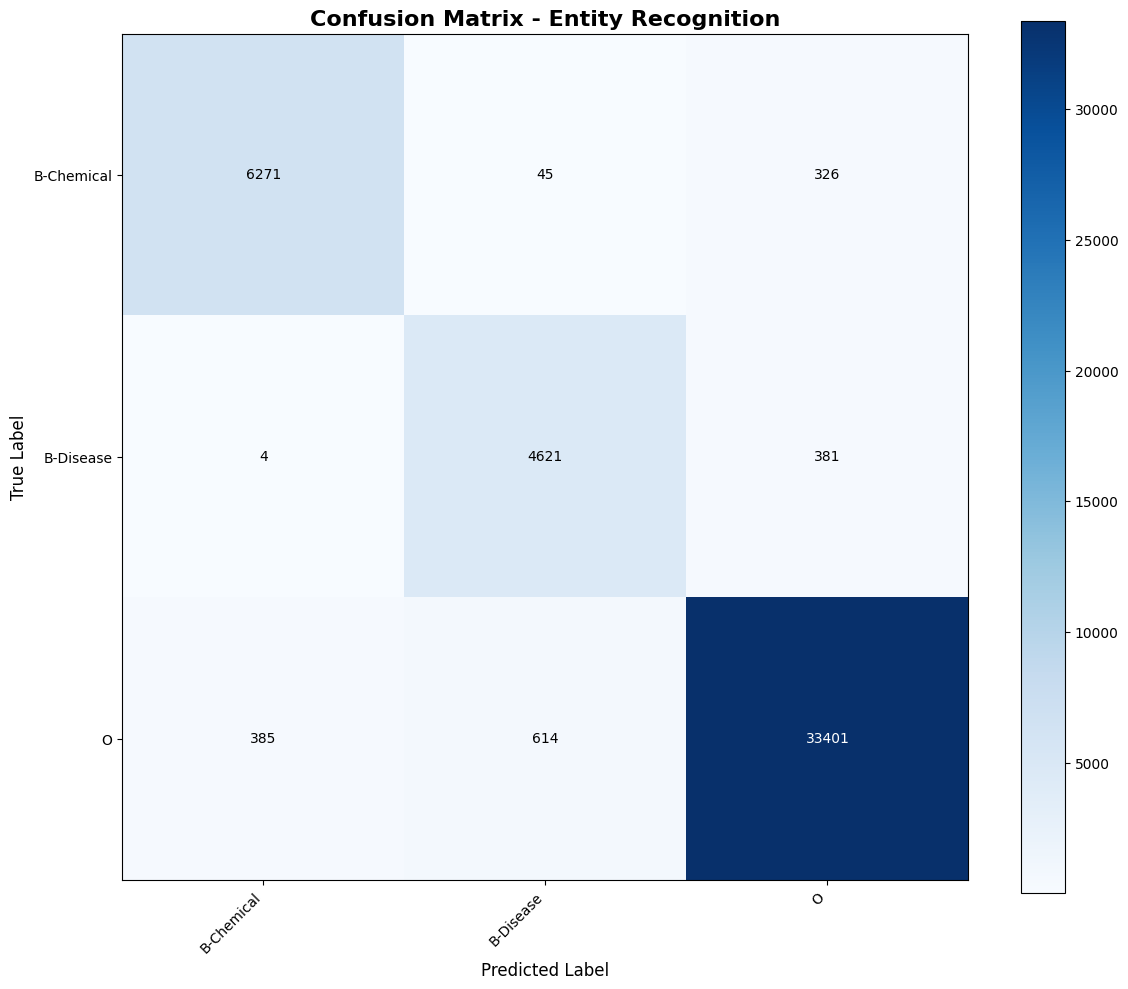

Generating confusion matrix for rule_based...
✓ Confusion matrix saved to /content/drive/MyDrive/AIML dataset/error_analysis/confusion_matrix_rule_based.png


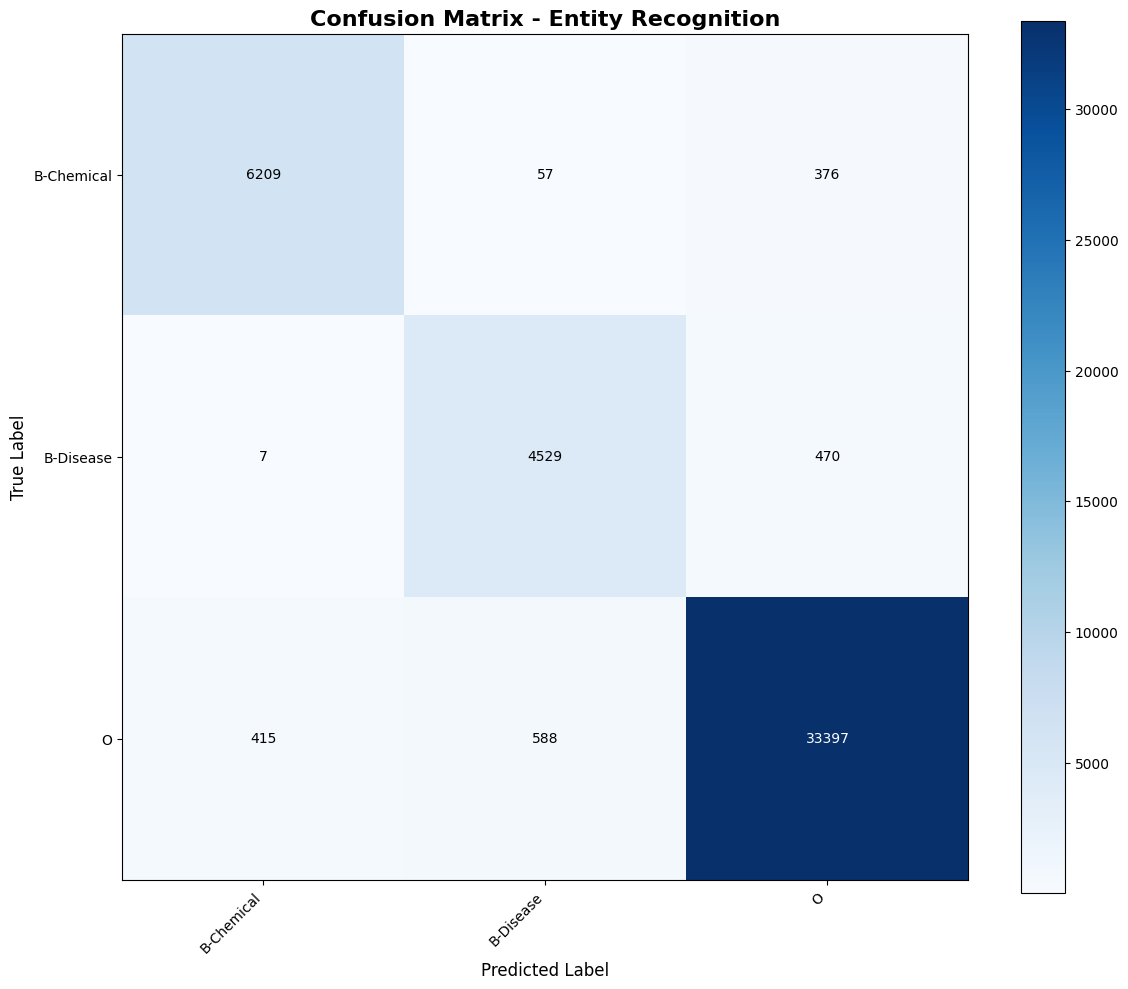

Generating confusion matrix for mlp_adaptive...
✓ Confusion matrix saved to /content/drive/MyDrive/AIML dataset/error_analysis/confusion_matrix_mlp_adaptive.png


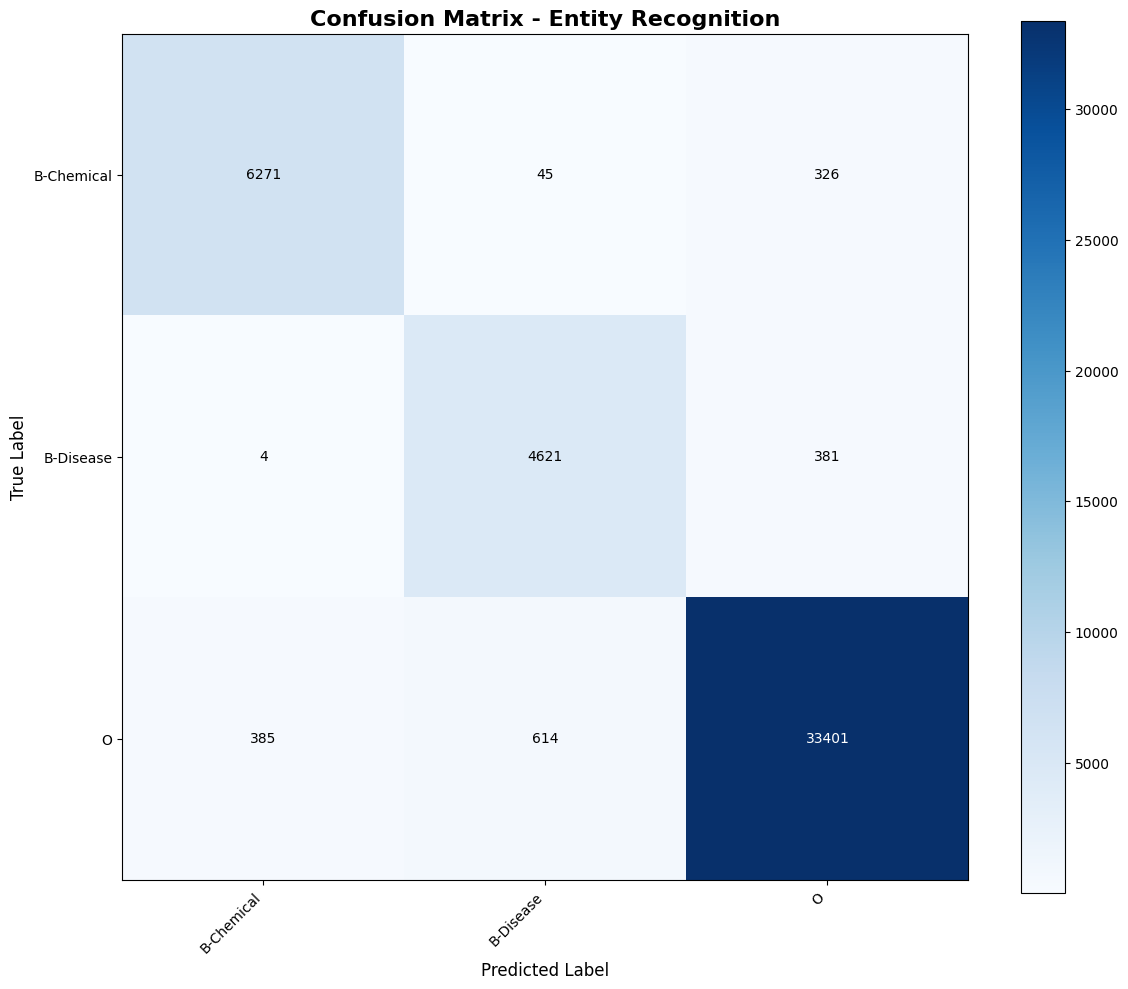


>>> SAVING RESULTS

✓ All error analysis results saved to /content/drive/MyDrive/AIML dataset/error_analysis

ERROR ANALYSIS SUMMARY

1. CLASS-WISE PERFORMANCE COMPARISON:
----------------------------------------------------------------------

Chemical:
  baseline       : F1 = 0.9441
  rule_based     : F1 = 0.9348
  mlp_adaptive   : F1 = 0.9441

Disease:
  baseline       : F1 = 0.9231
  rule_based     : F1 = 0.9047
  mlp_adaptive   : F1 = 0.9231

----------------------------------------------------------------------

2. PRUNING IMPACT ON ENTITIES:
----------------------------------------------------------------------

rule_based:
  Entity retention rate: 99.4%
  Entity tokens pruned:  68

mlp_adaptive:
  Entity retention rate: 100.0%
  Entity tokens pruned:  0

----------------------------------------------------------------------

3. FAIRNESS - RARE vs FREQUENT ENTITIES:
----------------------------------------------------------------------

baseline:
  Rare accuracy:      0.9231
  F

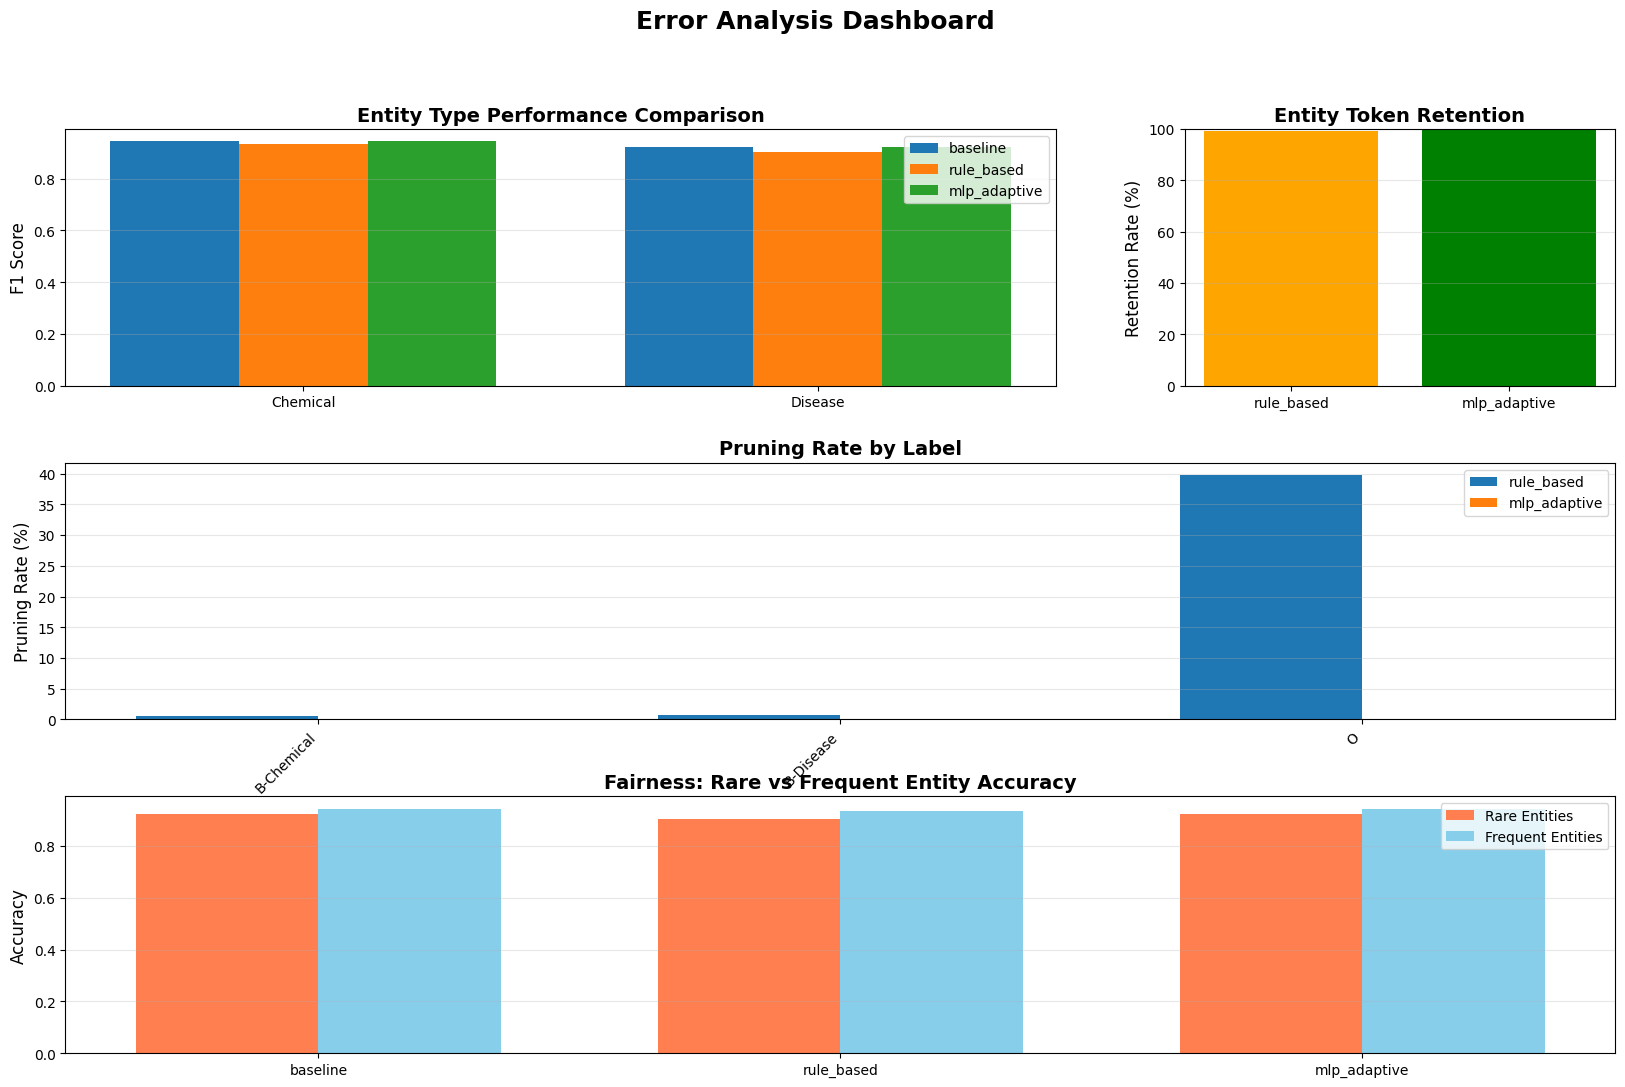


NEXT STEPS:
1. Review class-wise CSV files for detailed metrics
2. Analyze confusion matrices to identify error patterns
3. Check fairness_analysis.json for bias detection
4. Review pruning_stats JSON for entity retention
5. Use dashboard.png for presentations



In [ ]:
# ============================================================================
# STEP 11: ERROR ANALYSIS & FAIRNESS CHECK
# ============================================================================

import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from collections import defaultdict, Counter
from tqdm import tqdm
from seqeval.metrics import classification_report, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ============================================================================
# 1. CLASS-WISE PERFORMANCE ANALYSIS
# ============================================================================

def compute_class_wise_metrics(true_labels, pred_labels):
    """
    Compute per-class precision, recall, F1

    Args:
        true_labels: list of lists with true BIO labels
        pred_labels: list of lists with predicted BIO labels

    Returns:
        DataFrame with per-class metrics
    """

    from sklearn.metrics import classification_report as sklearn_report

    # Flatten labels for sklearn
    true_flat = [label for seq in true_labels for label in seq]
    pred_flat = [label for seq in pred_labels for label in seq]

    # Get unique labels
    unique_labels = sorted(set(true_flat + pred_flat))

    # Get classification report as dict
    report = sklearn_report(
        true_flat,
        pred_flat,
        labels=unique_labels,
        output_dict=True,
        zero_division=0
    )

    # Convert to DataFrame
    class_metrics = []

    for label in unique_labels:
        if label in report and label != 'accuracy':
            class_metrics.append({
                'Class': label,
                'Precision': report[label]['precision'],
                'Recall': report[label]['recall'],
                'F1-Score': report[label]['f1-score'],
                'Support': report[label]['support']
            })

    return pd.DataFrame(class_metrics)


def analyze_entity_type_performance(true_labels, pred_labels):
    """
    Analyze performance by entity type (Chemical, Disease)
    Aggregates B- and I- tags for each entity type
    """

    # Group by entity type
    entity_types = ['Chemical', 'Disease', 'O']

    results = []

    for entity_type in entity_types:
        true_type = []
        pred_type = []

        for true_seq, pred_seq in zip(true_labels, pred_labels):
            for t, p in zip(true_seq, pred_seq):
                # Match entity type
                if entity_type == 'O':
                    if t == 'O':
                        true_type.append(t)
                        pred_type.append(p)
                else:
                    if entity_type in t:
                        true_type.append(t)
                        pred_type.append(p)

        if len(true_type) > 0:
            # Compute metrics
            correct = sum(1 for t, p in zip(true_type, pred_type) if t == p)
            precision = correct / len(pred_type) if len(pred_type) > 0 else 0
            recall = correct / len(true_type) if len(true_type) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

            results.append({
                'Entity Type': entity_type,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'Support': len(true_type)
            })

    return pd.DataFrame(results)


# ============================================================================
# 2. PRUNING ERROR ANALYSIS
# ============================================================================

def analyze_pruned_tokens(
    model,
    dataloader,
    tokenizer,
    mode='rule_based',
    controller=None,
    max_samples=200,
    lambda_factor=0.5,
    min_keep_ratio=0.70
):
    """
    Analyze which tokens are being pruned and why

    Returns:
        - Statistics on pruned tokens
        - Examples of incorrectly pruned important tokens
        - Entity coverage analysis
    """

    model.eval()

    pruning_stats = {
        'total_tokens': 0,
        'pruned_tokens': 0,
        'pruned_entity_tokens': 0,  # Entity tokens that were pruned
        'kept_entity_tokens': 0,    # Entity tokens that were kept
        'pruned_by_label': defaultdict(int),
        'kept_by_label': defaultdict(int),
        'entropy_pruned': [],
        'entropy_kept': [],
        'errors': []  # Cases where pruning caused errors
    }

    sample_count = 0

    print(f"\nAnalyzing pruned tokens ({mode})...")

    for batch in tqdm(dataloader, desc="Pruning Analysis"):
        if sample_count >= max_samples:
            break

        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            if sample_count >= max_samples:
                break

            input_ids = batch["input_ids"][i].to(device)
            attention_mask = batch["attention_mask"][i].to(device)
            labels = batch["labels"][i]

            # Get entropy scores
            entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

            # Get predictions before pruning
            with torch.no_grad():
                outputs = model.bert(
                    input_ids=input_ids.unsqueeze(0),
                    attention_mask=attention_mask.unsqueeze(0),
                    output_hidden_states=True,
                    return_dict=True
                )
                hidden_states = outputs.last_hidden_state.squeeze(0)
                logits_before = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)
                preds_before = logits_before.argmax(dim=-1).cpu()

            # Get pruning mask
            if mode == 'rule_based':
                keep_mask = controller_get_keep_mask(
                    input_ids.cpu(),
                    attention_mask.cpu(),
                    tokenizer,
                    entropy_scores,
                    logits_before.cpu().detach(),
                    lambda_factor=lambda_factor,
                    min_keep_ratio=min_keep_ratio
                )
            elif mode == 'mlp_adaptive':
                keep_mask = mlp_controller_keep_mask(
                    controller,
                    input_ids.cpu(),
                    attention_mask.cpu(),
                    entropy_scores,
                    logits_before.cpu().detach(),
                    tokenizer,
                    threshold=0.5
                )

            # Analyze each token
            tokens = tokenizer.convert_ids_to_tokens(input_ids.cpu())

            for j in range(len(labels)):
                if attention_mask[j] == 0 or labels[j] == -100:
                    continue

                pruning_stats['total_tokens'] += 1

                true_label = id2label[labels[j].item()]
                is_entity = (true_label != 'O')

                if keep_mask[j] == 0:
                    # Token was pruned
                    pruning_stats['pruned_tokens'] += 1
                    pruning_stats['pruned_by_label'][true_label] += 1

                    if entropy_scores[j] >= 0:
                        pruning_stats['entropy_pruned'].append(entropy_scores[j])

                    if is_entity:
                        pruning_stats['pruned_entity_tokens'] += 1

                        # Record error case
                        pruning_stats['errors'].append({
                            'token': tokens[j],
                            'true_label': true_label,
                            'pred_before': id2label[preds_before[j].item()],
                            'entropy': entropy_scores[j],
                            'sample_id': sample_count
                        })
                else:
                    # Token was kept
                    pruning_stats['kept_by_label'][true_label] += 1

                    if entropy_scores[j] >= 0:
                        pruning_stats['entropy_kept'].append(entropy_scores[j])

                    if is_entity:
                        pruning_stats['kept_entity_tokens'] += 1

            sample_count += 1

    # Calculate entity retention rate
    total_entity_tokens = pruning_stats['pruned_entity_tokens'] + pruning_stats['kept_entity_tokens']
    entity_retention_rate = pruning_stats['kept_entity_tokens'] / total_entity_tokens if total_entity_tokens > 0 else 0

    pruning_stats['entity_retention_rate'] = entity_retention_rate
    pruning_stats['pruning_rate'] = pruning_stats['pruned_tokens'] / pruning_stats['total_tokens']

    return pruning_stats


def print_pruning_analysis(pruning_stats):
    """
    Print pruning statistics in readable format
    """

    print("\n" + "="*70)
    print("PRUNING ANALYSIS")
    print("="*70 + "\n")

    print(f"Total Tokens:           {pruning_stats['total_tokens']}")
    print(f"Pruned Tokens:          {pruning_stats['pruned_tokens']} ({pruning_stats['pruning_rate']*100:.1f}%)")
    print(f"Kept Tokens:            {pruning_stats['total_tokens'] - pruning_stats['pruned_tokens']}")

    print(f"\nEntity Token Analysis:")
    print(f"Entity Tokens Pruned:   {pruning_stats['pruned_entity_tokens']}")
    print(f"Entity Tokens Kept:     {pruning_stats['kept_entity_tokens']}")
    print(f"Entity Retention Rate:  {pruning_stats['entity_retention_rate']*100:.1f}%")

    print(f"\nEntropy Statistics:")
    if len(pruning_stats['entropy_pruned']) > 0:
        print(f"Pruned tokens entropy:  {np.mean(pruning_stats['entropy_pruned']):.3f} ± {np.std(pruning_stats['entropy_pruned']):.3f}")
    if len(pruning_stats['entropy_kept']) > 0:
        print(f"Kept tokens entropy:    {np.mean(pruning_stats['entropy_kept']):.3f} ± {np.std(pruning_stats['entropy_kept']):.3f}")

    print(f"\nPruned Tokens by Label:")
    for label, count in sorted(pruning_stats['pruned_by_label'].items(), key=lambda x: x[1], reverse=True):
        total_label = count + pruning_stats['kept_by_label'].get(label, 0)
        pct = 100 * count / total_label if total_label > 0 else 0
        print(f"  {label:15s}: {count:5d} / {total_label:5d} ({pct:.1f}% pruned)")

    print(f"\nTop 10 Incorrectly Pruned Entity Tokens:")
    error_examples = sorted(pruning_stats['errors'], key=lambda x: x['entropy'])[:10]
    for i, error in enumerate(error_examples, 1):
        print(f"{i:2d}. Token: '{error['token']:15s}' | "
              f"True: {error['true_label']:15s} | "
              f"Pred: {error['pred_before']:15s} | "
              f"Entropy: {error['entropy']:.3f}")

    print("="*70 + "\n")


# ============================================================================
# 3. FAIRNESS ANALYSIS - RARE ENTITY IMPACT
# ============================================================================

def analyze_rare_entity_impact(
    model,
    dataloader,
    tokenizer,
    mode='baseline',
    controller=None,
    max_samples=200,
    lambda_factor=0.5
):
    """
    Analyze model performance on rare vs frequent entities
    """

    model.eval()

    # Step 1: Count entity frequencies in dataset
    entity_counter = Counter()
    all_entities = []

    print("\nCounting entity frequencies...")

    for batch in dataloader:
        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            labels = batch["labels"][i]
            attention_mask = batch["attention_mask"][i]

            current_entity = []

            for j in range(len(labels)):
                if attention_mask[j] == 0 or labels[j] == -100:
                    continue

                label = id2label[labels[j].item()]

                if label.startswith('B-'):
                    # Start of new entity
                    if current_entity:
                        entity_text = ' '.join(current_entity)
                        entity_counter[entity_text] += 1
                        all_entities.append(entity_text)
                    current_entity = [label[2:]]  # Start new entity
                elif label.startswith('I-'):
                    current_entity.append(label[2:])
                else:
                    # Outside entity
                    if current_entity:
                        entity_text = ' '.join(current_entity)
                        entity_counter[entity_text] += 1
                        all_entities.append(entity_text)
                    current_entity = []

            if current_entity:
                entity_text = ' '.join(current_entity)
                entity_counter[entity_text] += 1
                all_entities.append(entity_text)

    # Define rare vs frequent
    frequency_threshold = np.percentile([count for count in entity_counter.values()], 25)

    rare_entities = {entity for entity, count in entity_counter.items() if count <= frequency_threshold}
    frequent_entities = {entity for entity, count in entity_counter.items() if count > frequency_threshold}

    print(f"Total unique entities:  {len(entity_counter)}")
    print(f"Rare entities:          {len(rare_entities)} (≤ {frequency_threshold} occurrences)")
    print(f"Frequent entities:      {len(frequent_entities)} (> {frequency_threshold} occurrences)")

    # Step 2: Evaluate on rare vs frequent
    rare_stats = {'true': [], 'pred': []}
    frequent_stats = {'true': [], 'pred': []}

    sample_count = 0

    print("\nEvaluating on rare vs frequent entities...")

    for batch in tqdm(dataloader, desc="Fairness Analysis"):
        if sample_count >= max_samples:
            break

        batch_size = batch["input_ids"].size(0)

        for i in range(batch_size):
            if sample_count >= max_samples:
                break

            input_ids = batch["input_ids"][i].to(device)
            attention_mask = batch["attention_mask"][i].to(device)
            labels = batch["labels"][i]

            # Get predictions based on mode
            if mode == 'baseline':
                with torch.no_grad():
                    outputs = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0)
                    )
                    preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

            elif mode == 'rule_based':
                entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

                with torch.no_grad():
                    outputs = model.bert(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=attention_mask.unsqueeze(0),
                        output_hidden_states=True,
                        return_dict=True
                    )
                    hidden_states = outputs.last_hidden_state.squeeze(0)
                    logits = model.classifier(hidden_states.unsqueeze(0)).squeeze(0)

                keep_mask = controller_get_keep_mask(
                    input_ids.cpu(),
                    attention_mask.cpu(),
                    tokenizer,
                    entropy_scores,
                    logits.cpu().detach(),
                    lambda_factor=lambda_factor,
                    min_keep_ratio=0.70
                )

                pruned_mask = attention_mask.clone()
                for j, keep in enumerate(keep_mask):
                    if keep == 0:
                        pruned_mask[j] = 0

                with torch.no_grad():
                    outputs = model(
                        input_ids=input_ids.unsqueeze(0),
                        attention_mask=pruned_mask.unsqueeze(0)
                    )
                    preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

            elif mode == 'mlp_adaptive':
                entropy_scores = compute_entropy_single(model, input_ids, attention_mask)

                results = adaptive_inference_with_recovery(
                    model=model,
                    controller=controller,
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    entropy_scores=entropy_scores,
                    tokenizer=tokenizer,
                    use_mlp=True,
                    enable_recovery=True
                )

                preds = results['predictions']

            # Collect entity-level predictions
            current_entity_type = None
            current_true_labels = []
            current_pred_labels = []

            for j in range(len(labels)):
                if attention_mask[j] == 0 or labels[j] == -100:
                    continue

                true_label = id2label[labels[j].item()]
                pred_label = id2label[preds[j].item()]

                if true_label.startswith('B-'):
                    # Start of entity - save previous
                    if current_entity_type:
                        entity_key = current_entity_type

                        if entity_key in rare_entities:
                            rare_stats['true'].extend(current_true_labels)
                            rare_stats['pred'].extend(current_pred_labels)
                        elif entity_key in frequent_entities:
                            frequent_stats['true'].extend(current_true_labels)
                            frequent_stats['pred'].extend(current_pred_labels)

                    current_entity_type = true_label[2:]
                    current_true_labels = [true_label]
                    current_pred_labels = [pred_label]

                elif true_label.startswith('I-'):
                    current_true_labels.append(true_label)
                    current_pred_labels.append(pred_label)

                else:
                    # End of entity
                    if current_entity_type:
                        entity_key = current_entity_type

                        if entity_key in rare_entities:
                            rare_stats['true'].extend(current_true_labels)
                            rare_stats['pred'].extend(current_pred_labels)
                        elif entity_key in frequent_entities:
                            frequent_stats['true'].extend(current_true_labels)
                            frequent_stats['pred'].extend(current_pred_labels)

                    current_entity_type = None
                    current_true_labels = []
                    current_pred_labels = []

            # Save last entity
            if current_entity_type:
                entity_key = current_entity_type

                if entity_key in rare_entities:
                    rare_stats['true'].extend(current_true_labels)
                    rare_stats['pred'].extend(current_pred_labels)
                elif entity_key in frequent_entities:
                    frequent_stats['true'].extend(current_true_labels)
                    frequent_stats['pred'].extend(current_pred_labels)

            sample_count += 1

    # Compute metrics
    results = {}

    if len(rare_stats['true']) > 0:
        rare_correct = sum(1 for t, p in zip(rare_stats['true'], rare_stats['pred']) if t == p)
        results['rare'] = {
            'accuracy': rare_correct / len(rare_stats['true']),
            'support': len(rare_stats['true'])
        }

    if len(frequent_stats['true']) > 0:
        freq_correct = sum(1 for t, p in zip(frequent_stats['true'], frequent_stats['pred']) if t == p)
        results['frequent'] = {
            'accuracy': freq_correct / len(frequent_stats['true']),
            'support': len(frequent_stats['true'])
        }

    return results, rare_entities, frequent_entities


def print_fairness_analysis(fairness_results):
    """
    Print fairness analysis results
    """

    print("\n" + "="*70)
    print("FAIRNESS ANALYSIS - RARE vs FREQUENT ENTITIES")
    print("="*70 + "\n")

    if 'rare' in fairness_results:
        print(f"Rare Entities:")
        print(f"  Accuracy:  {fairness_results['rare']['accuracy']:.4f}")
        print(f"  Support:   {fairness_results['rare']['support']}")

    if 'frequent' in fairness_results:
        print(f"\nFrequent Entities:")
        print(f"  Accuracy:  {fairness_results['frequent']['accuracy']:.4f}")
        print(f"  Support:   {fairness_results['frequent']['support']}")

    if 'rare' in fairness_results and 'frequent' in fairness_results:
        gap = fairness_results['frequent']['accuracy'] - fairness_results['rare']['accuracy']
        print(f"\nPerformance Gap: {gap:+.4f}")
        print(f"  (Positive = model favors frequent entities)")

    print("="*70 + "\n")


# ============================================================================
# 4. CONFUSION MATRIX ANALYSIS
# ============================================================================

def plot_confusion_matrix(true_labels, pred_labels, save_path=None):
    """
    Plot confusion matrix for entity types
    """

    from sklearn.metrics import confusion_matrix
    import itertools

    # Flatten
    true_flat = [label for seq in true_labels for label in seq]
    pred_flat = [label for seq in pred_labels for label in seq]

    # Get unique labels
    labels = sorted(set(true_flat + pred_flat))

    # Compute confusion matrix
    cm = confusion_matrix(true_flat, pred_flat, labels=labels)

    # Plot
    plt.figure(figsize=(12, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Entity Recognition', fontsize=16, fontweight='bold')
    plt.colorbar()

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, ha='right')
    plt.yticks(tick_marks, labels)

    # Add text annotations
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Confusion matrix saved to {save_path}")

    plt.show()


# ============================================================================
# 5. COMPREHENSIVE ERROR ANALYSIS REPORT
# ============================================================================

def generate_error_analysis_report(
    models_dict,
    dataloader,
    max_samples=200,
    save_dir="/content/drive/MyDrive/AIML dataset/error_analysis"
):
    """
    Generate complete error analysis report for all models
    """

    import os
    os.makedirs(save_dir, exist_ok=True)

    print("\n" + "="*70)
    print("STEP 11: COMPREHENSIVE ERROR ANALYSIS")
    print("="*70 + "\n")

    all_results = {}

    # ========================================================================
    # ANALYSIS 1: Class-wise Performance
    # ========================================================================
    print(">>> ANALYSIS 1: CLASS-WISE PERFORMANCE\n")

    for model_name, model_info in models_dict.items():
        print(f"Analyzing {model_name}...")

        # Collect predictions
        all_true = []
        all_pred = []

        sample_count = 0

        for batch in tqdm(dataloader, desc=f"Collecting {model_name}"):
            if sample_count >= max_samples:
                break

            batch_size = batch["input_ids"].size(0)

            for i in range(batch_size):
                if sample_count >= max_samples:
                    break

                input_ids = batch["input_ids"][i].to(device)
                attention_mask = batch["attention_mask"][i].to(device)
                labels = batch["labels"][i]

                # Get predictions
                if model_name == 'baseline':
                    with torch.no_grad():
                        outputs = model_info['model'](
                            input_ids=input_ids.unsqueeze(0),
                            attention_mask=attention_mask.unsqueeze(0)
                        )
                        preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

                elif model_name == 'rule_based':
                    entropy_scores = compute_entropy_single(
                        model_info['model'], input_ids, attention_mask
                    )

                    with torch.no_grad():
                        outputs = model_info['model'].bert(
                            input_ids=input_ids.unsqueeze(0),
                            attention_mask=attention_mask.unsqueeze(0),
                            output_hidden_states=True,
                            return_dict=True
                        )
                        hidden = outputs.last_hidden_state.squeeze(0)
                        logits = model_info['model'].classifier(hidden.unsqueeze(0)).squeeze(0)

                    keep_mask = controller_get_keep_mask(
                        input_ids.cpu(),
                        attention_mask.cpu(),
                        model_info['tokenizer'],
                        entropy_scores,
                        logits.cpu().detach(),
                        lambda_factor=0.5,
                        min_keep_ratio=0.70
                    )

                    pruned_mask = attention_mask.clone()
                    for j, keep in enumerate(keep_mask):
                        if keep == 0:
                            pruned_mask[j] = 0

                    with torch.no_grad():
                        outputs = model_info['model'](
                            input_ids=input_ids.unsqueeze(0),
                            attention_mask=pruned_mask.unsqueeze(0)
                        )
                        preds = outputs.logits.squeeze(0).argmax(dim=-1).cpu()

                elif model_name == 'mlp_adaptive':
                    entropy_scores = compute_entropy_single(
                        model_info['model'], input_ids, attention_mask
                    )

                    results = adaptive_inference_with_recovery(
                        model=model_info['model'],
                        controller=model_info['controller'],
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        entropy_scores=entropy_scores,
                        tokenizer=model_info['tokenizer'],
                        use_mlp=True,
                        enable_recovery=True
                    )

                    preds = results['predictions']

                # Collect labels
                seq_true = []
                seq_pred = []

                for j in range(len(labels)):
                    if attention_mask[j] == 1 and labels[j] != -100:
                        seq_true.append(id2label[labels[j].item()])
                        seq_pred.append(id2label[preds[j].item()])

                if len(seq_true) > 0:
                    all_true.append(seq_true)
                    all_pred.append(seq_pred)

                sample_count += 1

        # Compute class-wise metrics
        class_metrics = compute_class_wise_metrics(all_true, all_pred)
        entity_metrics = analyze_entity_type_performance(all_true, all_pred)

        all_results[model_name] = {
            'class_wise': class_metrics,
            'entity_type': entity_metrics,
            'true_labels': all_true,
            'pred_labels': all_pred
        }

        print(f"\nClass-wise Metrics for {model_name}:")
        print(class_metrics.to_string(index=False))
        print(f"\nEntity Type Metrics for {model_name}:")
        print(entity_metrics.to_string(index=False))
        print("\n" + "-"*70 + "\n")

    # ========================================================================
    # ANALYSIS 2: Pruning Error Analysis
    # ========================================================================
    print("\n>>> ANALYSIS 2: PRUNING ERROR ANALYSIS\n")

    # Rule-based pruning analysis
    print("Analyzing rule-based pruning...")
    rule_pruning_stats = analyze_pruned_tokens(
        models_dict['rule_based']['model'],
        dataloader,
        models_dict['rule_based']['tokenizer'],
        mode='rule_based',
        max_samples=max_samples
    )
    print_pruning_analysis(rule_pruning_stats)
    all_results['rule_based']['pruning_stats'] = rule_pruning_stats

    # MLP pruning analysis
    print("Analyzing MLP pruning...")
    mlp_pruning_stats = analyze_pruned_tokens(
        models_dict['mlp_adaptive']['model'],
        dataloader,
        models_dict['mlp_adaptive']['tokenizer'],
        mode='mlp_adaptive',
        controller=models_dict['mlp_adaptive']['controller'],
        max_samples=max_samples
    )
    print_pruning_analysis(mlp_pruning_stats)
    all_results['mlp_adaptive']['pruning_stats'] = mlp_pruning_stats

    # ========================================================================
    # ANALYSIS 3: Fairness - Rare Entity Impact
    # ========================================================================
    print("\n>>> ANALYSIS 3: FAIRNESS ANALYSIS\n")

    for model_name, model_info in models_dict.items():
        print(f"Fairness analysis for {model_name}...")

        controller = model_info.get('controller', None)

        fairness_results, rare_ent, freq_ent = analyze_rare_entity_impact(
            model_info['model'],
            dataloader,
            model_info['tokenizer'],
            mode=model_name,
            controller=controller,
            max_samples=max_samples
        )

        all_results[model_name]['fairness'] = fairness_results

        print(f"\n{model_name.upper()} - Fairness Results:")
        print_fairness_analysis(fairness_results)

    # ========================================================================
    # ANALYSIS 4: Confusion Matrices
    # ========================================================================
    print("\n>>> ANALYSIS 4: CONFUSION MATRICES\n")

    for model_name in models_dict.keys():
        print(f"Generating confusion matrix for {model_name}...")

        plot_confusion_matrix(
            all_results[model_name]['true_labels'],
            all_results[model_name]['pred_labels'],
            save_path=f"{save_dir}/confusion_matrix_{model_name}.png"
        )

    # ========================================================================
    # SAVE RESULTS
    # ========================================================================
    print("\n>>> SAVING RESULTS\n")

    # Save class-wise metrics
    for model_name in models_dict.keys():
        all_results[model_name]['class_wise'].to_csv(
            f"{save_dir}/class_wise_{model_name}.csv",
            index=False
        )
        all_results[model_name]['entity_type'].to_csv(
            f"{save_dir}/entity_type_{model_name}.csv",
            index=False
        )

    # Save pruning stats as JSON
    for model_name in ['rule_based', 'mlp_adaptive']:
        pruning_stats = all_results[model_name]['pruning_stats']

        # Remove non-serializable data
        pruning_json = {
            'total_tokens': pruning_stats['total_tokens'],
            'pruned_tokens': pruning_stats['pruned_tokens'],
            'pruning_rate': pruning_stats['pruning_rate'],
            'pruned_entity_tokens': pruning_stats['pruned_entity_tokens'],
            'kept_entity_tokens': pruning_stats['kept_entity_tokens'],
            'entity_retention_rate': pruning_stats['entity_retention_rate'],
            'avg_entropy_pruned': float(np.mean(pruning_stats['entropy_pruned'])) if len(pruning_stats['entropy_pruned']) > 0 else 0,
            'avg_entropy_kept': float(np.mean(pruning_stats['entropy_kept'])) if len(pruning_stats['entropy_kept']) > 0 else 0,
            'pruned_by_label': dict(pruning_stats['pruned_by_label']),
            'kept_by_label': dict(pruning_stats['kept_by_label'])
        }

        with open(f"{save_dir}/pruning_stats_{model_name}.json", 'w') as f:
            json.dump(pruning_json, f, indent=4)

    # Save fairness results
    fairness_summary = {}
    for model_name in models_dict.keys():
        fairness_summary[model_name] = all_results[model_name]['fairness']

    with open(f"{save_dir}/fairness_analysis.json", 'w') as f:
        json.dump(fairness_summary, f, indent=4)

    print(f"✓ All error analysis results saved to {save_dir}")

    # ========================================================================
    # GENERATE SUMMARY REPORT
    # ========================================================================
    print("\n" + "="*70)
    print("ERROR ANALYSIS SUMMARY")
    print("="*70 + "\n")

    print("1. CLASS-WISE PERFORMANCE COMPARISON:")
    print("-" * 70)

    for entity_type in ['Chemical', 'Disease']:
        print(f"\n{entity_type}:")
        for model_name in models_dict.keys():
            entity_df = all_results[model_name]['entity_type']
            row = entity_df[entity_df['Entity Type'] == entity_type]
            if not row.empty:
                f1 = row['F1-Score'].values[0]
                print(f"  {model_name:15s}: F1 = {f1:.4f}")

    print("\n" + "-" * 70)
    print("\n2. PRUNING IMPACT ON ENTITIES:")
    print("-" * 70)

    for model_name in ['rule_based', 'mlp_adaptive']:
        stats = all_results[model_name]['pruning_stats']
        print(f"\n{model_name}:")
        print(f"  Entity retention rate: {stats['entity_retention_rate']*100:.1f}%")
        print(f"  Entity tokens pruned:  {stats['pruned_entity_tokens']}")

    print("\n" + "-" * 70)
    print("\n3. FAIRNESS - RARE vs FREQUENT ENTITIES:")
    print("-" * 70)

    for model_name in models_dict.keys():
        fairness = all_results[model_name]['fairness']
        print(f"\n{model_name}:")
        if 'rare' in fairness and 'frequent' in fairness:
            gap = fairness['frequent']['accuracy'] - fairness['rare']['accuracy']
            print(f"  Rare accuracy:      {fairness['rare']['accuracy']:.4f}")
            print(f"  Frequent accuracy:  {fairness['frequent']['accuracy']:.4f}")
            print(f"  Performance gap:    {gap:+.4f}")

    print("\n" + "="*70)
    print("✓ ERROR ANALYSIS COMPLETE!")
    print("="*70 + "\n")

    return all_results


# ============================================================================
# 6. VISUALIZATION - ERROR ANALYSIS DASHBOARD
# ============================================================================

def create_error_analysis_dashboard(all_results, save_path=None):
    """
    Create comprehensive visualization dashboard
    """

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    models = list(all_results.keys())

    # ========================================================================
    # Plot 1: Entity Type F1 Comparison
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, :2])

    entity_types = ['Chemical', 'Disease']
    x = np.arange(len(entity_types))
    width = 0.25

    for idx, model_name in enumerate(models):
        f1_scores = []
        for entity_type in entity_types:
            df = all_results[model_name]['entity_type']
            row = df[df['Entity Type'] == entity_type]
            f1_scores.append(row['F1-Score'].values[0] if not row.empty else 0)

        ax1.bar(x + idx*width, f1_scores, width, label=model_name)

    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.set_title('Entity Type Performance Comparison', fontsize=14, fontweight='bold')
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(entity_types)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)

    # ========================================================================
    # Plot 2: Entity Retention Rate
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 2])

    retention_rates = []
    model_names_with_pruning = []

    for model_name in ['rule_based', 'mlp_adaptive']:
        if 'pruning_stats' in all_results[model_name]:
            stats = all_results[model_name]['pruning_stats']
            retention_rates.append(stats['entity_retention_rate'] * 100)
            model_names_with_pruning.append(model_name)

    colors = ['orange', 'green']
    ax2.bar(model_names_with_pruning, retention_rates, color=colors)
    ax2.set_ylabel('Retention Rate (%)', fontsize=12)
    ax2.set_title('Entity Token Retention', fontsize=14, fontweight='bold')
    ax2.set_ylim([0, 100])
    ax2.grid(axis='y', alpha=0.3)

    # ========================================================================
    # Plot 3: Pruning Rate by Label
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, :])

    # Get all labels
    all_labels = set()
    for model_name in ['rule_based', 'mlp_adaptive']:
        stats = all_results[model_name]['pruning_stats']
        all_labels.update(stats['pruned_by_label'].keys())

    all_labels = sorted(all_labels)

    x = np.arange(len(all_labels))
    width = 0.35

    for idx, model_name in enumerate(['rule_based', 'mlp_adaptive']):
        stats = all_results[model_name]['pruning_stats']
        pruning_rates = []

        for label in all_labels:
            pruned = stats['pruned_by_label'].get(label, 0)
            kept = stats['kept_by_label'].get(label, 0)
            total = pruned + kept
            rate = 100 * pruned / total if total > 0 else 0
            pruning_rates.append(rate)

        ax3.bar(x + idx*width, pruning_rates, width, label=model_name)

    ax3.set_ylabel('Pruning Rate (%)', fontsize=12)
    ax3.set_title('Pruning Rate by Label', fontsize=14, fontweight='bold')
    ax3.set_xticks(x + width/2)
    ax3.set_xticklabels(all_labels, rotation=45, ha='right')
    ax3.legend()
    ax3.grid(axis='y', alpha=0.3)

    # ========================================================================
    # Plot 4: Fairness Comparison
    # ========================================================================
    ax4 = fig.add_subplot(gs[2, :])

    fairness_data = []

    for model_name in models:
        fairness = all_results[model_name]['fairness']
        if 'rare' in fairness and 'frequent' in fairness:
            fairness_data.append({
                'Model': model_name,
                'Rare': fairness['rare']['accuracy'],
                'Frequent': fairness['frequent']['accuracy']
            })

    if fairness_data:
        fairness_df = pd.DataFrame(fairness_data)

        x = np.arange(len(fairness_df))
        width = 0.35

        ax4.bar(x - width/2, fairness_df['Rare'], width, label='Rare Entities', color='coral')
        ax4.bar(x + width/2, fairness_df['Frequent'], width, label='Frequent Entities', color='skyblue')

        ax4.set_ylabel('Accuracy', fontsize=12)
        ax4.set_title('Fairness: Rare vs Frequent Entity Accuracy', fontsize=14, fontweight='bold')
        ax4.set_xticks(x)
        ax4.set_xticklabels(fairness_df['Model'])
        ax4.legend()
        ax4.grid(axis='y', alpha=0.3)

    plt.suptitle('Error Analysis Dashboard', fontsize=18, fontweight='bold', y=0.98)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Dashboard saved to {save_path}")

    plt.show()


# ============================================================================
# 7. MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    print("\n" + "="*70)
    print("STEP 11: ERROR ANALYSIS & FAIRNESS CHECK")
    print("="*70 + "\n")

    # Load models
    models_dict = load_all_models()

    # Run comprehensive error analysis
    all_results = generate_error_analysis_report(
        models_dict,
        dev_loader,
        max_samples=200,
        save_dir="/content/drive/MyDrive/AIML dataset/error_analysis"
    )

    # Create visualization dashboard
    create_error_analysis_dashboard(
        all_results,
        save_path="/content/drive/MyDrive/AIML dataset/error_analysis/dashboard.png"
    )

    print("\n" + "="*70)
    print("NEXT STEPS:")
    print("="*70)
    print("1. Review class-wise CSV files for detailed metrics")
    print("2. Analyze confusion matrices to identify error patterns")
    print("3. Check fairness_analysis.json for bias detection")
    print("4. Review pruning_stats JSON for entity retention")
    print("5. Use dashboard.png for presentations")
    print("="*70 + "\n")